# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('data/text8') as f:
    text = f.read()

## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 16680599
Unique words: 63641


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is that probability that a word is discarded. Assign the subsampled data to `train_words`.

In [6]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

{0: 0.06363056866243233, 1: 0.035590868169662254, 2: 0.02497686084294695, 3: 0.02468520465002486, 4: 0.022313407330276328, 5: 0.01953604903516954, 6: 0.018966704972645167, 7: 0.015885220908433802, 8: 0.015013249823942174, 9: 0.011548985740859786, 10: 0.010980001377648369, 11: 0.007902294156223047, 12: 0.007510821403955577, 13: 0.007100764187185364, 14: 0.006996751135855493, 15: 0.006941537291316697, 16: 0.0068807481074270775, 17: 0.006762766732777402, 18: 0.006704255644536506, 19: 0.0065651119603079, 20: 0.0064854985123735664, 21: 0.006123581053654009, 22: 0.0059759844355709284, 23: 0.005731388902760626, 24: 0.005470427051210811, 25: 0.004587784887101477, 26: 0.004396364902723217, 27: 0.004368608105740087, 28: 0.0041332448552956645, 29: 0.003753042681500826, 30: 0.0037123966591367614, 31: 0.003673788932879449, 32: 0.0035269716633077744, 33: 0.00328453432637521, 34: 0.003271824950650753, 35: 0.0032116952155015538, 36: 0.0026592570206861277, 37: 0.002639773307900993, 38: 0.00238072985268

## Making batches

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you chose a random number of words to from the window.

In [7]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as one-hot encoded vectors. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [9]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

In [10]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [11]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [12]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [13]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [15]:
epochs = 100
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/100 Iteration: 100 Avg. Training loss: 5.6624 0.1075 sec/batch
Epoch 1/100 Iteration: 200 Avg. Training loss: 5.6451 0.1070 sec/batch
Epoch 1/100 Iteration: 300 Avg. Training loss: 5.5269 0.1065 sec/batch
Epoch 1/100 Iteration: 400 Avg. Training loss: 5.5969 0.1065 sec/batch
Epoch 1/100 Iteration: 500 Avg. Training loss: 5.5004 0.1071 sec/batch
Epoch 1/100 Iteration: 600 Avg. Training loss: 5.5574 0.1087 sec/batch
Epoch 1/100 Iteration: 700 Avg. Training loss: 5.5708 0.1062 sec/batch
Epoch 1/100 Iteration: 800 Avg. Training loss: 5.5868 0.1081 sec/batch
Epoch 1/100 Iteration: 900 Avg. Training loss: 5.4608 0.1082 sec/batch
Epoch 1/100 Iteration: 1000 Avg. Training loss: 5.4310 0.1077 sec/batch
Nearest to has: call, barreto, falsely, merry, lush, easily, vocalized, pulverized,
Nearest to these: oral, catastrophism, sufficiently, uca, johansson, frances, silverman, eisenstein,
Nearest to all: to, broadened, house, hercules, histoire, africanus, unaccompanied, formulations,
Neares

Epoch 1/100 Iteration: 4100 Avg. Training loss: 4.6816 0.1080 sec/batch
Epoch 1/100 Iteration: 4200 Avg. Training loss: 4.6772 0.1091 sec/batch
Epoch 1/100 Iteration: 4300 Avg. Training loss: 4.6030 0.1076 sec/batch
Epoch 1/100 Iteration: 4400 Avg. Training loss: 4.6257 0.1055 sec/batch
Epoch 1/100 Iteration: 4500 Avg. Training loss: 4.6295 0.1065 sec/batch
Epoch 1/100 Iteration: 4600 Avg. Training loss: 4.6439 0.1074 sec/batch
Epoch 2/100 Iteration: 4700 Avg. Training loss: 4.6100 0.0782 sec/batch
Epoch 2/100 Iteration: 4800 Avg. Training loss: 4.5477 0.1069 sec/batch
Epoch 2/100 Iteration: 4900 Avg. Training loss: 4.5281 0.1061 sec/batch
Epoch 2/100 Iteration: 5000 Avg. Training loss: 4.5294 0.1075 sec/batch
Nearest to has: call, vocalized, easily, radiate, discos, lush, falsely, contributing,
Nearest to these: sufficiently, oral, catastrophism, concorde, crescas, discrete, laysan, eisenstein,
Nearest to all: to, broadened, weaves, our, dismiss, then, whether, enjoyable,
Nearest to i

Epoch 2/100 Iteration: 8100 Avg. Training loss: 4.3255 0.1102 sec/batch
Epoch 2/100 Iteration: 8200 Avg. Training loss: 4.2981 0.1091 sec/batch
Epoch 2/100 Iteration: 8300 Avg. Training loss: 4.3745 0.1088 sec/batch
Epoch 2/100 Iteration: 8400 Avg. Training loss: 4.3739 0.1064 sec/batch
Epoch 2/100 Iteration: 8500 Avg. Training loss: 4.3734 0.1060 sec/batch
Epoch 2/100 Iteration: 8600 Avg. Training loss: 4.2757 0.1062 sec/batch
Epoch 2/100 Iteration: 8700 Avg. Training loss: 4.2854 0.1053 sec/batch
Epoch 2/100 Iteration: 8800 Avg. Training loss: 4.3224 0.1084 sec/batch
Epoch 2/100 Iteration: 8900 Avg. Training loss: 4.2052 0.1066 sec/batch
Epoch 2/100 Iteration: 9000 Avg. Training loss: 4.2992 0.1066 sec/batch
Nearest to has: vocalized, call, bodies, discos, radiate, contributing, maserati, local,
Nearest to these: concorde, sufficiently, oral, catastrophism, crescas, preserves, laysan, accretion,
Nearest to all: to, euphemisms, then, drawers, weaves, whether, broadened, dismiss,
Neare

Epoch 3/100 Iteration: 12100 Avg. Training loss: 4.1868 0.1073 sec/batch
Epoch 3/100 Iteration: 12200 Avg. Training loss: 4.1609 0.1081 sec/batch
Epoch 3/100 Iteration: 12300 Avg. Training loss: 4.1636 0.1093 sec/batch
Epoch 3/100 Iteration: 12400 Avg. Training loss: 4.1754 0.1063 sec/batch
Epoch 3/100 Iteration: 12500 Avg. Training loss: 4.1433 0.1076 sec/batch
Epoch 3/100 Iteration: 12600 Avg. Training loss: 4.1641 0.1066 sec/batch
Epoch 3/100 Iteration: 12700 Avg. Training loss: 4.1600 0.1081 sec/batch
Epoch 3/100 Iteration: 12800 Avg. Training loss: 4.1261 0.1079 sec/batch
Epoch 3/100 Iteration: 12900 Avg. Training loss: 4.1885 0.1078 sec/batch
Epoch 3/100 Iteration: 13000 Avg. Training loss: 4.2225 0.1060 sec/batch
Nearest to has: vocalized, call, bodies, juries, maserati, atlantean, discos, verifying,
Nearest to these: concorde, oral, catastrophism, crescas, formation, preserves, primary, sufficiently,
Nearest to all: to, held, euphemisms, then, dismiss, whether, weaves, reelecti

Epoch 4/100 Iteration: 16100 Avg. Training loss: 4.0385 0.1077 sec/batch
Epoch 4/100 Iteration: 16200 Avg. Training loss: 4.0415 0.1085 sec/batch
Epoch 4/100 Iteration: 16300 Avg. Training loss: 4.0730 0.1103 sec/batch
Epoch 4/100 Iteration: 16400 Avg. Training loss: 4.0569 0.1110 sec/batch
Epoch 4/100 Iteration: 16500 Avg. Training loss: 4.0623 0.1100 sec/batch
Epoch 4/100 Iteration: 16600 Avg. Training loss: 4.0953 0.1066 sec/batch
Epoch 4/100 Iteration: 16700 Avg. Training loss: 4.0785 0.1071 sec/batch
Epoch 4/100 Iteration: 16800 Avg. Training loss: 4.0773 0.1093 sec/batch
Epoch 4/100 Iteration: 16900 Avg. Training loss: 4.0902 0.1096 sec/batch
Epoch 4/100 Iteration: 17000 Avg. Training loss: 4.0770 0.1082 sec/batch
Nearest to has: vocalized, juries, bodies, call, atlantean, somali, verifying, its,
Nearest to these: concorde, preserves, oral, formation, catastrophism, crescas, waterway, distinctions,
Nearest to all: to, held, euphemisms, then, whose, positives, weaves, other,
Neare

Epoch 5/100 Iteration: 20100 Avg. Training loss: 4.0171 0.1101 sec/batch
Epoch 5/100 Iteration: 20200 Avg. Training loss: 4.0074 0.1067 sec/batch
Epoch 5/100 Iteration: 20300 Avg. Training loss: 3.9614 0.1063 sec/batch
Epoch 5/100 Iteration: 20400 Avg. Training loss: 3.9844 0.1081 sec/batch
Epoch 5/100 Iteration: 20500 Avg. Training loss: 4.0501 0.1068 sec/batch
Epoch 5/100 Iteration: 20600 Avg. Training loss: 3.9221 0.1054 sec/batch
Epoch 5/100 Iteration: 20700 Avg. Training loss: 3.9983 0.1067 sec/batch
Epoch 5/100 Iteration: 20800 Avg. Training loss: 3.9917 0.1072 sec/batch
Epoch 5/100 Iteration: 20900 Avg. Training loss: 3.9999 0.1082 sec/batch
Epoch 5/100 Iteration: 21000 Avg. Training loss: 3.9941 0.1059 sec/batch
Nearest to has: juries, bodies, call, verifying, somali, its, vocalized, atlantean,
Nearest to these: preserves, catastrophism, oral, concorde, formation, parasitism, waterway, idealization,
Nearest to all: held, then, euphemisms, to, whose, other, worst, records,
Neare

Epoch 6/100 Iteration: 24100 Avg. Training loss: 3.9582 0.1092 sec/batch
Epoch 6/100 Iteration: 24200 Avg. Training loss: 3.9881 0.1083 sec/batch
Epoch 6/100 Iteration: 24300 Avg. Training loss: 3.8546 0.1102 sec/batch
Epoch 6/100 Iteration: 24400 Avg. Training loss: 3.8999 0.1071 sec/batch
Epoch 6/100 Iteration: 24500 Avg. Training loss: 3.8996 0.1084 sec/batch
Epoch 6/100 Iteration: 24600 Avg. Training loss: 3.9045 0.1065 sec/batch
Epoch 6/100 Iteration: 24700 Avg. Training loss: 3.9292 0.1064 sec/batch
Epoch 6/100 Iteration: 24800 Avg. Training loss: 3.9692 0.1056 sec/batch
Epoch 6/100 Iteration: 24900 Avg. Training loss: 3.9218 0.1084 sec/batch
Epoch 6/100 Iteration: 25000 Avg. Training loss: 3.9259 0.1096 sec/batch
Nearest to has: juries, number, frazier, call, somali, its, geri, maserati,
Nearest to these: preserves, oral, providing, concorde, parasitism, formation, regards, waterway,
Nearest to all: then, held, other, euphemisms, worst, positives, whose, to,
Nearest to in: the, 

Epoch 7/100 Iteration: 28100 Avg. Training loss: 3.8866 0.1101 sec/batch
Epoch 7/100 Iteration: 28200 Avg. Training loss: 3.9213 0.1082 sec/batch
Epoch 7/100 Iteration: 28300 Avg. Training loss: 3.9005 0.1066 sec/batch
Epoch 7/100 Iteration: 28400 Avg. Training loss: 3.9111 0.1065 sec/batch
Epoch 7/100 Iteration: 28500 Avg. Training loss: 3.8910 0.1080 sec/batch
Epoch 7/100 Iteration: 28600 Avg. Training loss: 3.9274 0.1082 sec/batch
Epoch 7/100 Iteration: 28700 Avg. Training loss: 3.9117 0.1060 sec/batch
Epoch 7/100 Iteration: 28800 Avg. Training loss: 3.9713 0.1061 sec/batch
Epoch 7/100 Iteration: 28900 Avg. Training loss: 3.8200 0.1100 sec/batch
Epoch 7/100 Iteration: 29000 Avg. Training loss: 3.8736 0.1053 sec/batch
Nearest to has: number, its, juries, somali, as, the, recent, contributing,
Nearest to these: providing, formation, more, preserves, parasitism, vicinity, chess, oral,
Nearest to all: held, then, other, to, redeeming, whose, recieves, whether,
Nearest to in: the, a, of,

Epoch 7/100 Iteration: 32200 Avg. Training loss: 3.9052 0.1069 sec/batch
Epoch 7/100 Iteration: 32300 Avg. Training loss: 3.9138 0.1073 sec/batch
Epoch 8/100 Iteration: 32400 Avg. Training loss: 3.9348 0.0120 sec/batch
Epoch 8/100 Iteration: 32500 Avg. Training loss: 3.9039 0.1073 sec/batch
Epoch 8/100 Iteration: 32600 Avg. Training loss: 3.8748 0.1078 sec/batch
Epoch 8/100 Iteration: 32700 Avg. Training loss: 3.8722 0.1074 sec/batch
Epoch 8/100 Iteration: 32800 Avg. Training loss: 3.9225 0.1097 sec/batch
Epoch 8/100 Iteration: 32900 Avg. Training loss: 3.8509 0.1073 sec/batch
Epoch 8/100 Iteration: 33000 Avg. Training loss: 3.8612 0.1093 sec/batch
Nearest to has: as, number, its, even, juries, well, somali, afrikaans,
Nearest to these: providing, preserves, parasitism, waterway, formation, kath, federally, vicinity,
Nearest to all: then, other, and, held, recieves, groups, of, whose,
Nearest to in: the, a, of, and, both, also, with, normalised,
Nearest to not: that, be, affiliations, 

Epoch 8/100 Iteration: 36400 Avg. Training loss: 3.8238 0.1053 sec/batch
Epoch 8/100 Iteration: 36500 Avg. Training loss: 3.8588 0.1052 sec/batch
Epoch 8/100 Iteration: 36600 Avg. Training loss: 3.8127 0.1061 sec/batch
Epoch 8/100 Iteration: 36700 Avg. Training loss: 3.8524 0.1061 sec/batch
Epoch 8/100 Iteration: 36800 Avg. Training loss: 3.8971 0.1066 sec/batch
Epoch 8/100 Iteration: 36900 Avg. Training loss: 3.8432 0.1055 sec/batch
Epoch 8/100 Iteration: 37000 Avg. Training loss: 3.9205 0.1056 sec/batch
Nearest to has: as, well, number, been, recent, the, its, somali,
Nearest to these: providing, including, federally, more, preserves, kath, formation, regards,
Nearest to all: then, other, held, groups, worst, smoothness, whose, can,
Nearest to in: the, a, of, and, both, with, on, also,
Nearest to not: be, that, did, withheld, fact, but, affiliations, mmorpgs,
Nearest to to: and, the, from, other, of, with, in, asked,
Nearest to was: that, by, the, had, in, became, a, fanshawe,
Neares

Epoch 9/100 Iteration: 40800 Avg. Training loss: 3.8939 0.1055 sec/batch
Epoch 9/100 Iteration: 40900 Avg. Training loss: 3.9165 0.1054 sec/batch
Epoch 9/100 Iteration: 41000 Avg. Training loss: 3.8219 0.1061 sec/batch
Nearest to has: as, been, the, in, its, currently, well, that,
Nearest to these: including, of, often, providing, more, kath, regards, ulfilas,
Nearest to all: then, other, held, and, worst, groups, redeeming, propels,
Nearest to in: the, of, and, a, both, with, s, on,
Nearest to not: be, that, long, fact, but, affiliations, did, is,
Nearest to to: and, the, of, from, other, in, with, up,
Nearest to was: had, that, became, after, by, in, the, jacobus,
Nearest to for: and, with, from, a, of, well, the, as,
Nearest to additional: dortmund, utilise, every, bytes, chuck, springer, ketos, leftover,
Nearest to primarily: talkers, kwanza, aafc, grammys, concerned, ecuadorians, substantial, trend,
Nearest to cost: expensive, harker, bomarc, sensationalism, zane, row, modificatio

Epoch 10/100 Iteration: 45100 Avg. Training loss: 3.8777 0.1064 sec/batch
Epoch 10/100 Iteration: 45200 Avg. Training loss: 3.8245 0.1058 sec/batch
Epoch 10/100 Iteration: 45300 Avg. Training loss: 3.8946 0.1063 sec/batch
Epoch 10/100 Iteration: 45400 Avg. Training loss: 3.8994 0.1054 sec/batch
Epoch 10/100 Iteration: 45500 Avg. Training loss: 3.8739 0.1047 sec/batch
Epoch 10/100 Iteration: 45600 Avg. Training loss: 3.8327 0.1068 sec/batch
Epoch 10/100 Iteration: 45700 Avg. Training loss: 3.7678 0.1042 sec/batch
Epoch 10/100 Iteration: 45800 Avg. Training loss: 3.8621 0.1050 sec/batch
Epoch 10/100 Iteration: 45900 Avg. Training loss: 3.7425 0.1055 sec/batch
Epoch 10/100 Iteration: 46000 Avg. Training loss: 3.8473 0.1065 sec/batch
Nearest to has: as, been, the, well, currently, recent, its, in,
Nearest to these: including, of, often, more, providing, many, well, are,
Nearest to all: then, and, of, are, groups, other, the, they,
Nearest to in: the, of, and, a, on, with, is, both,
Nearest

Epoch 11/100 Iteration: 49600 Avg. Training loss: 3.7799 0.1054 sec/batch
Epoch 11/100 Iteration: 49700 Avg. Training loss: 3.8119 0.1063 sec/batch
Epoch 11/100 Iteration: 49800 Avg. Training loss: 3.8468 0.1063 sec/batch
Epoch 11/100 Iteration: 49900 Avg. Training loss: 3.8921 0.1058 sec/batch
Epoch 11/100 Iteration: 50000 Avg. Training loss: 3.9131 0.1059 sec/batch
Nearest to has: as, been, the, well, currently, have, that, in,
Nearest to these: including, often, providing, of, many, well, more, were,
Nearest to all: are, then, and, of, the, other, one, groups,
Nearest to in: the, of, a, and, an, to, by, s,
Nearest to not: that, be, but, to, fact, the, did, would,
Nearest to to: and, the, in, from, of, for, this, other,
Nearest to was: the, that, by, in, had, after, first, became,
Nearest to for: and, the, from, a, with, of, as, is,
Nearest to additional: dortmund, every, utilise, ketos, chuck, bytes, leftover, over,
Nearest to primarily: kwanza, grammys, most, concerned, including, 

Epoch 12/100 Iteration: 54100 Avg. Training loss: 3.8003 0.1079 sec/batch
Epoch 12/100 Iteration: 54200 Avg. Training loss: 3.7825 0.1060 sec/batch
Epoch 12/100 Iteration: 54300 Avg. Training loss: 3.7866 0.1056 sec/batch
Epoch 12/100 Iteration: 54400 Avg. Training loss: 3.8914 0.1057 sec/batch
Epoch 12/100 Iteration: 54500 Avg. Training loss: 3.7784 0.1065 sec/batch
Epoch 12/100 Iteration: 54600 Avg. Training loss: 3.8654 0.1055 sec/batch
Epoch 12/100 Iteration: 54700 Avg. Training loss: 3.8703 0.1049 sec/batch
Epoch 12/100 Iteration: 54800 Avg. Training loss: 3.8216 0.1066 sec/batch
Epoch 12/100 Iteration: 54900 Avg. Training loss: 3.7842 0.1057 sec/batch
Epoch 12/100 Iteration: 55000 Avg. Training loss: 3.7741 0.1050 sec/batch
Nearest to has: as, been, the, in, is, currently, well, since,
Nearest to these: often, including, providing, of, more, and, many, certain,
Nearest to all: then, are, of, and, can, that, other, the,
Nearest to in: the, of, a, and, by, an, with, is,
Nearest to 

Epoch 13/100 Iteration: 58700 Avg. Training loss: 3.8101 0.1067 sec/batch
Epoch 13/100 Iteration: 58800 Avg. Training loss: 3.7799 0.1068 sec/batch
Epoch 13/100 Iteration: 58900 Avg. Training loss: 3.7739 0.1066 sec/batch
Epoch 13/100 Iteration: 59000 Avg. Training loss: 3.8528 0.1056 sec/batch
Nearest to has: as, been, the, is, currently, that, in, well,
Nearest to these: including, many, often, are, of, were, and, certain,
Nearest to all: are, then, of, and, two, one, can, this,
Nearest to in: the, of, and, a, an, is, as, both,
Nearest to not: be, that, but, to, is, the, or, in,
Nearest to to: and, the, in, of, from, other, for, this,
Nearest to was: first, the, in, that, by, after, a, had,
Nearest to for: and, the, as, a, is, of, with, on,
Nearest to additional: over, every, leftover, dortmund, ketos, bytes, utilise, pronounces,
Nearest to primarily: most, kwanza, crouching, mafia, substantial, pardo, including, ecuadorians,
Nearest to cost: expensive, levies, bomarc, khama, adversi

Epoch 14/100 Iteration: 63100 Avg. Training loss: 3.7801 0.1073 sec/batch
Epoch 14/100 Iteration: 63200 Avg. Training loss: 3.7730 0.1040 sec/batch
Epoch 14/100 Iteration: 63300 Avg. Training loss: 3.7902 0.1023 sec/batch
Epoch 14/100 Iteration: 63400 Avg. Training loss: 3.7692 0.1017 sec/batch
Epoch 14/100 Iteration: 63500 Avg. Training loss: 3.7569 0.1004 sec/batch
Epoch 14/100 Iteration: 63600 Avg. Training loss: 3.7901 0.0976 sec/batch
Epoch 14/100 Iteration: 63700 Avg. Training loss: 3.7704 0.0970 sec/batch
Epoch 14/100 Iteration: 63800 Avg. Training loss: 3.8606 0.0988 sec/batch
Epoch 14/100 Iteration: 63900 Avg. Training loss: 3.8695 0.0956 sec/batch
Epoch 14/100 Iteration: 64000 Avg. Training loss: 3.8433 0.0973 sec/batch
Nearest to has: as, been, well, is, currently, have, the, in,
Nearest to these: often, many, were, of, are, including, some, certain,
Nearest to all: are, then, one, two, and, of, from, can,
Nearest to in: the, of, and, a, s, by, both, at,
Nearest to not: be, 

Epoch 15/100 Iteration: 67600 Avg. Training loss: 3.7650 0.0905 sec/batch
Epoch 15/100 Iteration: 67700 Avg. Training loss: 3.7676 0.0914 sec/batch
Epoch 15/100 Iteration: 67800 Avg. Training loss: 3.7975 0.0909 sec/batch
Epoch 15/100 Iteration: 67900 Avg. Training loss: 3.7550 0.0949 sec/batch
Epoch 15/100 Iteration: 68000 Avg. Training loss: 3.7763 0.0915 sec/batch
Nearest to has: as, been, well, is, that, in, the, have,
Nearest to these: are, often, many, including, of, certain, were, and,
Nearest to all: are, then, of, two, and, from, groups, one,
Nearest to in: the, a, of, and, is, both, with, as,
Nearest to not: be, that, but, however, to, in, the, other,
Nearest to to: the, and, from, in, this, of, other, for,
Nearest to was: the, in, by, had, became, after, first, that,
Nearest to for: and, the, a, with, from, is, as, of,
Nearest to additional: over, every, bytes, ketos, attracts, leftover, dy, utilise,
Nearest to primarily: referred, including, kwanza, ecuadorians, mafia, crou

Epoch 16/100 Iteration: 72000 Avg. Training loss: 3.7884 0.0926 sec/batch
Nearest to has: been, as, the, well, is, currently, that, have,
Nearest to these: many, often, are, and, others, of, certain, including,
Nearest to all: are, and, two, then, one, of, from, the,
Nearest to in: the, of, a, and, is, as, both, to,
Nearest to not: be, but, that, the, in, to, is, however,
Nearest to to: and, the, in, of, this, from, not, for,
Nearest to was: had, the, by, in, became, first, earlier, that,
Nearest to for: and, the, a, is, with, by, of, from,
Nearest to additional: over, every, bytes, dortmund, leftover, pronounces, contributing, dy,
Nearest to primarily: referred, many, most, including, mafia, ecuadorians, of, based,
Nearest to cost: expensive, khama, squares, levies, phenomenally, adversity, cheaper, tn,
Nearest to engine: engines, piston, petrol, junkers, combustion, efficiencies, railway, injecting,
Nearest to creation: created, genesis, convertibility, metrical, creationists, divine

Epoch 17/100 Iteration: 76100 Avg. Training loss: 3.7322 0.0933 sec/batch
Epoch 17/100 Iteration: 76200 Avg. Training loss: 3.7235 0.0920 sec/batch
Epoch 17/100 Iteration: 76300 Avg. Training loss: 3.7452 0.0922 sec/batch
Epoch 17/100 Iteration: 76400 Avg. Training loss: 3.7553 0.0925 sec/batch
Epoch 17/100 Iteration: 76500 Avg. Training loss: 3.7723 0.0921 sec/batch
Epoch 17/100 Iteration: 76600 Avg. Training loss: 3.8022 0.0958 sec/batch
Epoch 17/100 Iteration: 76700 Avg. Training loss: 3.7879 0.0938 sec/batch
Epoch 17/100 Iteration: 76800 Avg. Training loss: 3.7463 0.0931 sec/batch
Epoch 17/100 Iteration: 76900 Avg. Training loss: 3.7675 0.0924 sec/batch
Epoch 17/100 Iteration: 77000 Avg. Training loss: 3.7676 0.0960 sec/batch
Nearest to has: as, been, is, currently, well, its, that, since,
Nearest to these: many, often, are, and, some, certain, were, include,
Nearest to all: are, and, two, then, one, of, some, from,
Nearest to in: of, the, a, and, both, as, was, to,
Nearest to not:

Epoch 18/100 Iteration: 80600 Avg. Training loss: 3.7967 0.0928 sec/batch
Epoch 18/100 Iteration: 80700 Avg. Training loss: 3.7728 0.0960 sec/batch
Epoch 18/100 Iteration: 80800 Avg. Training loss: 3.7433 0.0926 sec/batch
Epoch 18/100 Iteration: 80900 Avg. Training loss: 3.7355 0.0925 sec/batch
Epoch 18/100 Iteration: 81000 Avg. Training loss: 3.7615 0.0964 sec/batch
Nearest to has: been, as, is, well, that, currently, its, since,
Nearest to these: many, and, including, some, were, are, in, often,
Nearest to all: are, and, the, then, one, two, that, of,
Nearest to in: the, of, a, and, with, as, by, both,
Nearest to not: be, but, that, the, to, however, have, thus,
Nearest to to: the, in, this, and, for, on, of, other,
Nearest to was: had, became, by, in, that, but, the, after,
Nearest to for: and, the, a, is, by, on, with, in,
Nearest to additional: bytes, over, every, contributing, pronounces, feigning, indiana, die,
Nearest to primarily: pardo, based, of, ecuadorians, most, concerned

Epoch 19/100 Iteration: 85100 Avg. Training loss: 3.7293 0.0936 sec/batch
Epoch 19/100 Iteration: 85200 Avg. Training loss: 3.7842 0.0922 sec/batch
Epoch 19/100 Iteration: 85300 Avg. Training loss: 3.7750 0.0957 sec/batch
Epoch 19/100 Iteration: 85400 Avg. Training loss: 3.7034 0.0932 sec/batch
Epoch 19/100 Iteration: 85500 Avg. Training loss: 3.7627 0.0923 sec/batch
Epoch 19/100 Iteration: 85600 Avg. Training loss: 3.7482 0.0922 sec/batch
Epoch 19/100 Iteration: 85700 Avg. Training loss: 3.7352 0.0957 sec/batch
Epoch 19/100 Iteration: 85800 Avg. Training loss: 3.7334 0.0924 sec/batch
Epoch 19/100 Iteration: 85900 Avg. Training loss: 3.7549 0.0925 sec/batch
Epoch 19/100 Iteration: 86000 Avg. Training loss: 3.7440 0.0931 sec/batch
Nearest to has: been, as, is, well, currently, its, that, the,
Nearest to these: are, many, and, some, often, others, including, were,
Nearest to all: are, and, this, one, two, then, the, only,
Nearest to in: the, of, and, a, is, as, with, which,
Nearest to no

Epoch 20/100 Iteration: 89700 Avg. Training loss: 3.7229 0.0916 sec/batch
Epoch 20/100 Iteration: 89800 Avg. Training loss: 3.7486 0.0922 sec/batch
Epoch 20/100 Iteration: 89900 Avg. Training loss: 3.7592 0.0924 sec/batch
Epoch 20/100 Iteration: 90000 Avg. Training loss: 3.7523 0.0958 sec/batch
Nearest to has: as, been, is, that, its, currently, since, the,
Nearest to these: are, many, and, including, often, in, of, the,
Nearest to all: are, and, then, the, following, of, two, some,
Nearest to in: the, of, a, and, as, by, to, which,
Nearest to not: but, be, that, only, same, however, in, is,
Nearest to to: and, the, in, this, for, other, from, but,
Nearest to was: by, first, had, that, the, in, earlier, but,
Nearest to for: and, the, a, in, as, by, an, is,
Nearest to additional: over, bytes, contributing, every, called, pied, pronounces, derive,
Nearest to primarily: of, and, based, including, many, pardo, as, prominence,
Nearest to cost: expensive, usd, therus, ability, levies, incomp

Epoch 21/100 Iteration: 94100 Avg. Training loss: 3.7226 0.0934 sec/batch
Epoch 21/100 Iteration: 94200 Avg. Training loss: 3.7584 0.0921 sec/batch
Epoch 21/100 Iteration: 94300 Avg. Training loss: 3.7255 0.0923 sec/batch
Epoch 21/100 Iteration: 94400 Avg. Training loss: 3.7001 0.0918 sec/batch
Epoch 21/100 Iteration: 94500 Avg. Training loss: 3.8328 0.0926 sec/batch
Epoch 21/100 Iteration: 94600 Avg. Training loss: 3.7357 0.0920 sec/batch
Epoch 21/100 Iteration: 94700 Avg. Training loss: 3.7210 0.0955 sec/batch
Epoch 21/100 Iteration: 94800 Avg. Training loss: 3.7037 0.0923 sec/batch
Epoch 21/100 Iteration: 94900 Avg. Training loss: 3.7452 0.0955 sec/batch
Epoch 21/100 Iteration: 95000 Avg. Training loss: 3.7463 0.0921 sec/batch
Nearest to has: been, as, is, that, well, its, have, since,
Nearest to these: often, and, are, were, many, including, others, some,
Nearest to all: are, and, the, following, of, that, two, for,
Nearest to in: the, a, and, of, to, first, which, as,
Nearest to n

Epoch 22/100 Iteration: 98800 Avg. Training loss: 3.7282 0.0955 sec/batch
Epoch 22/100 Iteration: 98900 Avg. Training loss: 3.7129 0.0912 sec/batch
Epoch 22/100 Iteration: 99000 Avg. Training loss: 3.7098 0.0949 sec/batch
Nearest to has: as, been, is, well, since, currently, that, its,
Nearest to these: often, are, many, and, some, the, including, include,
Nearest to all: are, and, the, for, following, two, then, only,
Nearest to in: the, of, and, a, with, is, as, which,
Nearest to not: be, but, that, however, same, is, to, in,
Nearest to to: the, and, this, in, of, also, be, as,
Nearest to was: had, by, first, after, the, but, from, in,
Nearest to for: and, a, of, is, as, the, an, by,
Nearest to additional: over, bytes, derive, contributing, orissa, include, every, pronounces,
Nearest to primarily: based, pardo, prominence, many, of, clearer, mafia, and,
Nearest to cost: expensive, levies, prohibitive, usd, incompatible, therus, imac, promotions,
Nearest to engine: engines, piston, ef

Epoch 23/100 Iteration: 103100 Avg. Training loss: 3.7135 0.0931 sec/batch
Epoch 23/100 Iteration: 103200 Avg. Training loss: 3.6243 0.0913 sec/batch
Epoch 23/100 Iteration: 103300 Avg. Training loss: 3.6881 0.0914 sec/batch
Epoch 23/100 Iteration: 103400 Avg. Training loss: 3.7415 0.0952 sec/batch
Epoch 23/100 Iteration: 103500 Avg. Training loss: 3.7268 0.0928 sec/batch
Epoch 23/100 Iteration: 103600 Avg. Training loss: 3.6881 0.0923 sec/batch
Epoch 23/100 Iteration: 103700 Avg. Training loss: 3.7638 0.0914 sec/batch
Epoch 23/100 Iteration: 103800 Avg. Training loss: 3.7696 0.0914 sec/batch
Epoch 23/100 Iteration: 103900 Avg. Training loss: 3.7089 0.0915 sec/batch
Epoch 23/100 Iteration: 104000 Avg. Training loss: 3.7154 0.0948 sec/batch
Nearest to has: been, as, is, well, that, its, since, a,
Nearest to these: and, are, many, including, some, often, the, were,
Nearest to all: are, and, some, then, following, the, two, for,
Nearest to in: the, of, and, a, as, which, to, from,
Nearest

Epoch 24/100 Iteration: 107700 Avg. Training loss: 3.7102 0.0969 sec/batch
Epoch 24/100 Iteration: 107800 Avg. Training loss: 3.6767 0.0932 sec/batch
Epoch 24/100 Iteration: 107900 Avg. Training loss: 3.6736 0.0961 sec/batch
Epoch 24/100 Iteration: 108000 Avg. Training loss: 3.7269 0.0940 sec/batch
Nearest to has: as, is, been, that, its, well, the, a,
Nearest to these: are, many, and, often, including, various, some, more,
Nearest to all: are, and, following, for, the, two, one, some,
Nearest to in: the, and, of, a, as, to, s, with,
Nearest to not: be, but, that, is, the, however, same, thus,
Nearest to to: the, and, in, for, this, of, but, from,
Nearest to was: had, by, first, after, the, but, that, later,
Nearest to for: and, the, from, is, a, by, of, as,
Nearest to additional: over, bytes, called, every, orissa, contributing, ways, pronounces,
Nearest to primarily: based, and, of, clearer, most, highly, many, combination,
Nearest to cost: expensive, costs, usd, prohibitive, cheaper

Epoch 25/100 Iteration: 112100 Avg. Training loss: 3.7594 0.0975 sec/batch
Epoch 25/100 Iteration: 112200 Avg. Training loss: 3.6209 0.0921 sec/batch
Epoch 25/100 Iteration: 112300 Avg. Training loss: 3.6950 0.0919 sec/batch
Epoch 25/100 Iteration: 112400 Avg. Training loss: 3.6887 0.0915 sec/batch
Epoch 25/100 Iteration: 112500 Avg. Training loss: 3.6353 0.0920 sec/batch
Epoch 25/100 Iteration: 112600 Avg. Training loss: 3.7163 0.0957 sec/batch
Epoch 25/100 Iteration: 112700 Avg. Training loss: 3.7535 0.0932 sec/batch
Epoch 25/100 Iteration: 112800 Avg. Training loss: 3.7275 0.0935 sec/batch
Epoch 25/100 Iteration: 112900 Avg. Training loss: 3.6700 0.0932 sec/batch
Epoch 25/100 Iteration: 113000 Avg. Training loss: 3.7857 0.0924 sec/batch
Nearest to has: as, been, is, well, that, its, currently, since,
Nearest to these: are, often, include, many, and, others, including, some,
Nearest to all: are, and, two, following, some, of, the, that,
Nearest to in: the, a, of, and, as, to, both, s

Epoch 26/100 Iteration: 116700 Avg. Training loss: 3.7590 0.0920 sec/batch
Epoch 26/100 Iteration: 116800 Avg. Training loss: 3.6802 0.0921 sec/batch
Epoch 26/100 Iteration: 116900 Avg. Training loss: 3.6414 0.0921 sec/batch
Epoch 26/100 Iteration: 117000 Avg. Training loss: 3.7024 0.0924 sec/batch
Nearest to has: as, is, been, that, currently, its, well, a,
Nearest to these: are, and, often, include, other, others, the, of,
Nearest to all: are, and, following, of, the, for, that, as,
Nearest to in: the, a, of, and, is, as, to, with,
Nearest to not: be, that, but, however, is, same, which, in,
Nearest to to: and, in, the, this, for, also, of, that,
Nearest to was: had, first, that, after, the, but, became, as,
Nearest to for: a, and, of, from, by, as, is, the,
Nearest to additional: contributing, include, over, pronounces, ashford, upon, ways, their,
Nearest to primarily: of, and, clearer, based, highly, especially, pardo, important,
Nearest to cost: usd, prohibitive, costs, expensive,

Epoch 27/100 Iteration: 121100 Avg. Training loss: 3.7358 0.0927 sec/batch
Epoch 27/100 Iteration: 121200 Avg. Training loss: 3.7129 0.0918 sec/batch
Epoch 27/100 Iteration: 121300 Avg. Training loss: 3.7262 0.0953 sec/batch
Epoch 27/100 Iteration: 121400 Avg. Training loss: 3.6926 0.0915 sec/batch
Epoch 27/100 Iteration: 121500 Avg. Training loss: 3.6186 0.0915 sec/batch
Epoch 27/100 Iteration: 121600 Avg. Training loss: 3.6981 0.0925 sec/batch
Epoch 27/100 Iteration: 121700 Avg. Training loss: 3.6019 0.0946 sec/batch
Epoch 27/100 Iteration: 121800 Avg. Training loss: 3.6789 0.0929 sec/batch
Epoch 27/100 Iteration: 121900 Avg. Training loss: 3.7207 0.0919 sec/batch
Epoch 27/100 Iteration: 122000 Avg. Training loss: 3.7086 0.0952 sec/batch
Nearest to has: as, that, is, well, been, since, the, its,
Nearest to these: many, are, and, include, often, including, have, others,
Nearest to all: are, and, following, of, that, two, their, some,
Nearest to in: the, and, a, of, to, which, is, s,
N

Epoch 28/100 Iteration: 125700 Avg. Training loss: 3.7275 0.0912 sec/batch
Epoch 28/100 Iteration: 125800 Avg. Training loss: 3.7053 0.0939 sec/batch
Epoch 28/100 Iteration: 125900 Avg. Training loss: 3.7173 0.0941 sec/batch
Epoch 28/100 Iteration: 126000 Avg. Training loss: 3.7453 0.0929 sec/batch
Nearest to has: as, is, been, it, the, its, a, that,
Nearest to these: are, and, of, include, including, many, were, the,
Nearest to all: are, and, two, the, then, that, following, only,
Nearest to in: the, and, a, to, of, with, as, by,
Nearest to not: be, that, but, to, the, only, is, however,
Nearest to to: in, the, and, of, this, but, also, as,
Nearest to was: had, the, a, in, after, first, as, it,
Nearest to for: and, as, of, a, by, is, the, with,
Nearest to additional: called, ashford, pronounces, include, and, over, contributing, by,
Nearest to primarily: of, especially, and, as, is, use, based, many,
Nearest to cost: prohibitive, expensive, usd, conquering, cheaper, levies, dollars, i

Epoch 29/100 Iteration: 130100 Avg. Training loss: 3.6973 0.0931 sec/batch
Epoch 29/100 Iteration: 130200 Avg. Training loss: 3.6900 0.0923 sec/batch
Epoch 29/100 Iteration: 130300 Avg. Training loss: 3.6463 0.0921 sec/batch
Epoch 29/100 Iteration: 130400 Avg. Training loss: 3.7256 0.0961 sec/batch
Epoch 29/100 Iteration: 130500 Avg. Training loss: 3.6687 0.0920 sec/batch
Epoch 29/100 Iteration: 130600 Avg. Training loss: 3.7466 0.0918 sec/batch
Epoch 29/100 Iteration: 130700 Avg. Training loss: 3.6323 0.0923 sec/batch
Epoch 29/100 Iteration: 130800 Avg. Training loss: 3.6888 0.0923 sec/batch
Epoch 29/100 Iteration: 130900 Avg. Training loss: 3.6968 0.0923 sec/batch
Epoch 29/100 Iteration: 131000 Avg. Training loss: 3.6035 0.0914 sec/batch
Nearest to has: as, been, is, well, since, its, that, it,
Nearest to these: include, are, many, and, often, some, including, various,
Nearest to all: and, are, of, the, following, that, for, some,
Nearest to in: the, of, a, and, is, to, for, as,
Near

Epoch 30/100 Iteration: 134800 Avg. Training loss: 3.7154 0.0911 sec/batch
Epoch 30/100 Iteration: 134900 Avg. Training loss: 3.6694 0.0913 sec/batch
Epoch 30/100 Iteration: 135000 Avg. Training loss: 3.7232 0.0917 sec/batch
Nearest to has: as, been, well, is, since, it, that, a,
Nearest to these: include, are, many, and, others, including, were, some,
Nearest to all: and, are, of, one, the, some, two, three,
Nearest to in: the, and, a, of, as, for, by, with,
Nearest to not: but, be, that, only, if, the, to, is,
Nearest to to: the, and, in, this, but, from, up, of,
Nearest to was: the, had, became, first, a, by, in, later,
Nearest to for: and, a, as, by, the, in, of, an,
Nearest to additional: bytes, over, include, called, ashford, by, contributing, every,
Nearest to primarily: especially, and, as, is, of, clearer, use, wide,
Nearest to cost: costs, usd, expensive, cheaper, predicts, levies, prohibitive, pricing,
Nearest to engine: engines, piston, wronged, analytical, newtonian, chalc

Epoch 31/100 Iteration: 139100 Avg. Training loss: 3.6872 0.0936 sec/batch
Epoch 31/100 Iteration: 139200 Avg. Training loss: 3.7286 0.0934 sec/batch
Epoch 31/100 Iteration: 139300 Avg. Training loss: 3.6784 0.0907 sec/batch
Epoch 31/100 Iteration: 139400 Avg. Training loss: 3.6836 0.0942 sec/batch
Epoch 31/100 Iteration: 139500 Avg. Training loss: 3.6694 0.0913 sec/batch
Epoch 31/100 Iteration: 139600 Avg. Training loss: 3.6903 0.0903 sec/batch
Epoch 31/100 Iteration: 139700 Avg. Training loss: 3.7214 0.0904 sec/batch
Epoch 31/100 Iteration: 139800 Avg. Training loss: 3.7157 0.0910 sec/batch
Epoch 31/100 Iteration: 139900 Avg. Training loss: 3.7252 0.0908 sec/batch
Epoch 31/100 Iteration: 140000 Avg. Training loss: 3.6317 0.0912 sec/batch
Nearest to has: as, is, been, since, its, the, in, that,
Nearest to these: many, are, often, include, and, only, others, some,
Nearest to all: and, are, the, of, they, some, following, for,
Nearest to in: the, and, of, a, is, to, by, also,
Nearest to

Epoch 32/100 Iteration: 143700 Avg. Training loss: 3.6862 0.0906 sec/batch
Epoch 32/100 Iteration: 143800 Avg. Training loss: 3.7289 0.0910 sec/batch
Epoch 32/100 Iteration: 143900 Avg. Training loss: 3.6867 0.0911 sec/batch
Epoch 32/100 Iteration: 144000 Avg. Training loss: 3.7152 0.0907 sec/batch
Nearest to has: as, been, is, since, that, well, however, its,
Nearest to these: only, are, some, and, many, others, were, often,
Nearest to all: for, and, are, some, two, called, that, from,
Nearest to in: the, of, and, a, to, at, was, with,
Nearest to not: be, but, that, to, only, did, however, the,
Nearest to to: in, the, and, that, also, of, from, be,
Nearest to was: the, had, in, that, it, a, earlier, by,
Nearest to for: and, a, as, by, the, of, an, in,
Nearest to additional: pronounces, ashford, include, bytes, over, called, uncredited, emerald,
Nearest to primarily: and, mafia, as, especially, is, than, referred, pardo,
Nearest to cost: costs, usd, expensive, expense, prohibitive, ena

Epoch 33/100 Iteration: 148100 Avg. Training loss: 3.7659 0.0337 sec/batch
Epoch 33/100 Iteration: 148200 Avg. Training loss: 3.6689 0.0950 sec/batch
Epoch 33/100 Iteration: 148300 Avg. Training loss: 3.7050 0.0928 sec/batch
Epoch 33/100 Iteration: 148400 Avg. Training loss: 3.6945 0.0920 sec/batch
Epoch 33/100 Iteration: 148500 Avg. Training loss: 3.7433 0.0951 sec/batch
Epoch 33/100 Iteration: 148600 Avg. Training loss: 3.6659 0.0926 sec/batch
Epoch 33/100 Iteration: 148700 Avg. Training loss: 3.7371 0.0924 sec/batch
Epoch 33/100 Iteration: 148800 Avg. Training loss: 3.6474 0.0919 sec/batch
Epoch 33/100 Iteration: 148900 Avg. Training loss: 3.6889 0.0917 sec/batch
Epoch 33/100 Iteration: 149000 Avg. Training loss: 3.6682 0.0931 sec/batch
Nearest to has: been, as, is, that, a, it, only, well,
Nearest to these: are, many, others, only, and, some, include, often,
Nearest to all: and, are, three, two, one, of, for, the,
Nearest to in: the, and, a, of, to, as, after, at,
Nearest to not: b

Epoch 34/100 Iteration: 152700 Avg. Training loss: 3.7225 0.0085 sec/batch
Epoch 34/100 Iteration: 152800 Avg. Training loss: 3.7229 0.0917 sec/batch
Epoch 34/100 Iteration: 152900 Avg. Training loss: 3.6887 0.0917 sec/batch
Epoch 34/100 Iteration: 153000 Avg. Training loss: 3.6723 0.0914 sec/batch
Nearest to has: as, been, is, since, well, that, currently, it,
Nearest to these: are, some, and, many, were, include, others, often,
Nearest to all: are, some, and, for, called, set, two, of,
Nearest to in: the, of, and, a, to, was, by, with,
Nearest to not: but, be, that, thus, only, same, to, however,
Nearest to to: the, in, and, from, was, this, but, of,
Nearest to was: the, had, in, his, he, first, to, a,
Nearest to for: a, and, as, by, is, in, of, the,
Nearest to additional: include, emerald, pronounces, ashford, supplemental, bytes, ways, uncredited,
Nearest to primarily: especially, referred, clearer, citizens, pardo, most, varies, popularity,
Nearest to cost: costs, usd, expense, ex

Epoch 34/100 Iteration: 157100 Avg. Training loss: 3.6963 0.0930 sec/batch
Epoch 34/100 Iteration: 157200 Avg. Training loss: 3.7005 0.0951 sec/batch
Epoch 34/100 Iteration: 157300 Avg. Training loss: 3.6966 0.0927 sec/batch
Epoch 35/100 Iteration: 157400 Avg. Training loss: 3.7125 0.0753 sec/batch
Epoch 35/100 Iteration: 157500 Avg. Training loss: 3.7116 0.0952 sec/batch
Epoch 35/100 Iteration: 157600 Avg. Training loss: 3.6902 0.0944 sec/batch
Epoch 35/100 Iteration: 157700 Avg. Training loss: 3.7542 0.0912 sec/batch
Epoch 35/100 Iteration: 157800 Avg. Training loss: 3.6759 0.0916 sec/batch
Epoch 35/100 Iteration: 157900 Avg. Training loss: 3.6784 0.0926 sec/batch
Epoch 35/100 Iteration: 158000 Avg. Training loss: 3.6606 0.0944 sec/batch
Nearest to has: as, been, is, since, the, well, currently, a,
Nearest to these: often, include, many, although, others, and, only, were,
Nearest to all: two, are, and, for, one, seven, that, in,
Nearest to in: the, a, and, of, to, for, with, as,
Near

Epoch 35/100 Iteration: 161800 Avg. Training loss: 3.6828 0.0918 sec/batch
Epoch 35/100 Iteration: 161900 Avg. Training loss: 3.7060 0.0914 sec/batch
Epoch 36/100 Iteration: 162000 Avg. Training loss: 3.7371 0.0506 sec/batch
Nearest to has: been, is, as, since, well, a, the, s,
Nearest to these: are, many, often, and, others, some, although, well,
Nearest to all: are, and, some, three, furthermore, two, any, one,
Nearest to in: the, and, a, of, also, by, which, was,
Nearest to not: but, that, be, only, some, however, did, is,
Nearest to to: the, and, would, in, that, was, but, be,
Nearest to was: the, had, a, in, later, became, but, to,
Nearest to for: and, by, a, of, as, the, in, from,
Nearest to additional: emerald, include, ways, uncredited, fade, reflecting, die, choose,
Nearest to primarily: especially, clearer, still, and, highly, mainly, many, dissemination,
Nearest to cost: costs, usd, expensive, prohibitive, dollars, cheaper, predicts, payment,
Nearest to engine: engines, pist

Epoch 36/100 Iteration: 166100 Avg. Training loss: 3.7017 0.0964 sec/batch
Epoch 36/100 Iteration: 166200 Avg. Training loss: 3.6144 0.0917 sec/batch
Epoch 36/100 Iteration: 166300 Avg. Training loss: 3.7297 0.0924 sec/batch
Epoch 36/100 Iteration: 166400 Avg. Training loss: 3.6995 0.0928 sec/batch
Epoch 36/100 Iteration: 166500 Avg. Training loss: 3.6726 0.0920 sec/batch
Epoch 37/100 Iteration: 166600 Avg. Training loss: 3.7519 0.0279 sec/batch
Epoch 37/100 Iteration: 166700 Avg. Training loss: 3.6896 0.0925 sec/batch
Epoch 37/100 Iteration: 166800 Avg. Training loss: 3.6894 0.0919 sec/batch
Epoch 37/100 Iteration: 166900 Avg. Training loss: 3.6841 0.0920 sec/batch
Epoch 37/100 Iteration: 167000 Avg. Training loss: 3.7339 0.0919 sec/batch
Nearest to has: been, as, is, since, well, only, fact, it,
Nearest to these: many, some, are, and, other, others, often, only,
Nearest to all: and, are, for, some, following, called, that, which,
Nearest to in: the, and, a, of, to, with, as, was,
Nea

Epoch 37/100 Iteration: 170800 Avg. Training loss: 3.6043 0.0915 sec/batch
Epoch 37/100 Iteration: 170900 Avg. Training loss: 3.6952 0.0960 sec/batch
Epoch 37/100 Iteration: 171000 Avg. Training loss: 3.6745 0.0921 sec/batch
Nearest to has: as, been, is, well, in, that, a, the,
Nearest to these: others, are, and, many, some, various, include, often,
Nearest to all: and, are, some, from, following, that, set, which,
Nearest to in: the, a, and, of, for, as, which, s,
Nearest to not: be, that, but, only, other, same, because, did,
Nearest to to: the, this, and, that, for, a, be, in,
Nearest to was: had, the, in, that, became, first, after, by,
Nearest to for: and, a, in, of, by, the, as, from,
Nearest to additional: include, logical, and, or, through, uncredited, emerald, reflecting,
Nearest to primarily: clearer, and, especially, many, of, other, commonly, as,
Nearest to cost: costs, usd, expensive, optimized, payment, predicts, prohibitive, paid,
Nearest to engine: engines, piston, niko

Epoch 38/100 Iteration: 175100 Avg. Training loss: 3.7142 0.0949 sec/batch
Epoch 38/100 Iteration: 175200 Avg. Training loss: 3.6390 0.0926 sec/batch
Epoch 38/100 Iteration: 175300 Avg. Training loss: 3.6449 0.0938 sec/batch
Epoch 38/100 Iteration: 175400 Avg. Training loss: 3.6681 0.0918 sec/batch
Epoch 38/100 Iteration: 175500 Avg. Training loss: 3.6619 0.0954 sec/batch
Epoch 38/100 Iteration: 175600 Avg. Training loss: 3.7089 0.0927 sec/batch
Epoch 38/100 Iteration: 175700 Avg. Training loss: 3.6703 0.0918 sec/batch
Epoch 38/100 Iteration: 175800 Avg. Training loss: 3.7005 0.0953 sec/batch
Epoch 39/100 Iteration: 175900 Avg. Training loss: 3.6820 0.0693 sec/batch
Epoch 39/100 Iteration: 176000 Avg. Training loss: 3.7308 0.0925 sec/batch
Nearest to has: been, as, is, well, since, that, an, currently,
Nearest to these: only, are, others, and, some, including, were, with,
Nearest to all: are, only, following, this, in, from, they, for,
Nearest to in: the, and, a, of, to, was, with, by,

Epoch 39/100 Iteration: 179800 Avg. Training loss: 3.6604 0.0934 sec/batch
Epoch 39/100 Iteration: 179900 Avg. Training loss: 3.5778 0.0936 sec/batch
Epoch 39/100 Iteration: 180000 Avg. Training loss: 3.7221 0.0919 sec/batch
Nearest to has: as, been, is, well, that, the, its, since,
Nearest to these: some, and, are, others, only, various, often, many,
Nearest to all: and, are, some, only, from, set, this, the,
Nearest to in: the, and, a, of, for, as, by, both,
Nearest to not: but, that, be, same, is, any, if, only,
Nearest to to: the, this, and, but, that, in, a, would,
Nearest to was: had, after, became, the, later, in, from, first,
Nearest to for: and, a, in, of, the, by, is, from,
Nearest to additional: include, ashford, uncredited, supplemental, emerald, of, over, certifying,
Nearest to primarily: especially, of, clearer, including, also, among, many, other,
Nearest to cost: costs, paid, usd, ability, expensive, dollars, optimized, equals,
Nearest to engine: engines, piston, exhaus

Epoch 40/100 Iteration: 184100 Avg. Training loss: 3.7444 0.0941 sec/batch
Epoch 40/100 Iteration: 184200 Avg. Training loss: 3.7449 0.0928 sec/batch
Epoch 40/100 Iteration: 184300 Avg. Training loss: 3.7182 0.0957 sec/batch
Epoch 40/100 Iteration: 184400 Avg. Training loss: 3.7050 0.0925 sec/batch
Epoch 40/100 Iteration: 184500 Avg. Training loss: 3.6068 0.0917 sec/batch
Epoch 40/100 Iteration: 184600 Avg. Training loss: 3.6708 0.0923 sec/batch
Epoch 40/100 Iteration: 184700 Avg. Training loss: 3.5952 0.0933 sec/batch
Epoch 40/100 Iteration: 184800 Avg. Training loss: 3.7164 0.0965 sec/batch
Epoch 40/100 Iteration: 184900 Avg. Training loss: 3.7052 0.0927 sec/batch
Epoch 40/100 Iteration: 185000 Avg. Training loss: 3.6934 0.0923 sec/batch
Nearest to has: been, is, as, well, that, its, since, it,
Nearest to these: some, only, are, often, many, although, and, well,
Nearest to all: and, are, some, for, that, this, in, called,
Nearest to in: the, a, and, of, to, was, with, for,
Nearest to

Epoch 41/100 Iteration: 188800 Avg. Training loss: 3.7467 0.0918 sec/batch
Epoch 41/100 Iteration: 188900 Avg. Training loss: 3.7356 0.0916 sec/batch
Epoch 41/100 Iteration: 189000 Avg. Training loss: 3.6880 0.0921 sec/batch
Nearest to has: as, is, the, been, in, since, well, of,
Nearest to these: in, are, some, their, and, often, many, various,
Nearest to all: some, and, from, for, which, that, are, so,
Nearest to in: the, of, and, s, a, to, as, with,
Nearest to not: but, be, that, can, is, only, same, thus,
Nearest to to: the, and, in, of, from, also, that, but,
Nearest to was: had, in, became, the, after, by, first, as,
Nearest to for: of, in, and, the, by, is, a, an,
Nearest to additional: and, by, with, the, a, ashford, as, include,
Nearest to primarily: of, and, especially, developed, to, as, also, clearer,
Nearest to cost: costs, usd, optimized, paid, downside, savings, expense, value,
Nearest to engine: engines, piston, combustion, universelle, unmik, petrol, newtonian, modifie

Epoch 42/100 Iteration: 193100 Avg. Training loss: 3.6820 0.0927 sec/batch
Epoch 42/100 Iteration: 193200 Avg. Training loss: 3.7753 0.0921 sec/batch
Epoch 42/100 Iteration: 193300 Avg. Training loss: 3.6402 0.0922 sec/batch
Epoch 42/100 Iteration: 193400 Avg. Training loss: 3.7918 0.0919 sec/batch
Epoch 42/100 Iteration: 193500 Avg. Training loss: 3.7092 0.0953 sec/batch
Epoch 42/100 Iteration: 193600 Avg. Training loss: 3.7613 0.0928 sec/batch
Epoch 42/100 Iteration: 193700 Avg. Training loss: 3.6491 0.0916 sec/batch
Epoch 42/100 Iteration: 193800 Avg. Training loss: 3.5970 0.0907 sec/batch
Epoch 42/100 Iteration: 193900 Avg. Training loss: 3.6929 0.0918 sec/batch
Epoch 42/100 Iteration: 194000 Avg. Training loss: 3.6189 0.0928 sec/batch
Nearest to has: as, been, is, the, well, since, a, in,
Nearest to these: others, some, are, often, many, although, well, various,
Nearest to all: and, some, that, are, for, with, called, set,
Nearest to in: the, of, a, and, s, was, with, for,
Nearest

Epoch 43/100 Iteration: 197900 Avg. Training loss: 3.6896 0.0945 sec/batch
Epoch 43/100 Iteration: 198000 Avg. Training loss: 3.7549 0.0933 sec/batch
Nearest to has: as, been, is, it, that, the, since, a,
Nearest to these: and, are, although, were, only, include, as, of,
Nearest to all: and, are, that, some, the, from, in, for,
Nearest to in: the, and, of, a, as, to, for, from,
Nearest to not: that, but, be, is, same, it, others, however,
Nearest to to: the, and, in, but, this, as, a, from,
Nearest to was: had, in, the, became, to, his, by, he,
Nearest to for: and, of, the, in, by, a, is, from,
Nearest to additional: over, smuggled, include, reflecting, by, pronounces, called, uncredited,
Nearest to primarily: especially, highly, furthermore, of, developed, as, significant, prevalent,
Nearest to cost: usd, costs, dollars, expense, optimized, downside, economical, prohibitive,
Nearest to engine: engines, piston, carnot, nikolaus, petrol, combustion, air, universelle,
Nearest to creation

Epoch 44/100 Iteration: 202100 Avg. Training loss: 3.7116 0.0928 sec/batch
Epoch 44/100 Iteration: 202200 Avg. Training loss: 3.6702 0.0922 sec/batch
Epoch 44/100 Iteration: 202300 Avg. Training loss: 3.7086 0.0952 sec/batch
Epoch 44/100 Iteration: 202400 Avg. Training loss: 3.6957 0.0937 sec/batch
Epoch 44/100 Iteration: 202500 Avg. Training loss: 3.7053 0.0942 sec/batch
Epoch 44/100 Iteration: 202600 Avg. Training loss: 3.7336 0.0948 sec/batch
Epoch 44/100 Iteration: 202700 Avg. Training loss: 3.7531 0.0931 sec/batch
Epoch 44/100 Iteration: 202800 Avg. Training loss: 3.7240 0.0918 sec/batch
Epoch 44/100 Iteration: 202900 Avg. Training loss: 3.7242 0.0923 sec/batch
Epoch 44/100 Iteration: 203000 Avg. Training loss: 3.6298 0.0919 sec/batch
Nearest to has: been, as, is, in, since, the, well, have,
Nearest to these: are, and, some, others, include, in, various, many,
Nearest to all: and, some, so, are, this, that, from, one,
Nearest to in: the, and, of, a, by, as, with, both,
Nearest to 

Epoch 45/100 Iteration: 206800 Avg. Training loss: 3.6578 0.0916 sec/batch
Epoch 45/100 Iteration: 206900 Avg. Training loss: 3.6648 0.0916 sec/batch
Epoch 45/100 Iteration: 207000 Avg. Training loss: 3.6332 0.0965 sec/batch
Nearest to has: as, been, is, that, it, a, the, in,
Nearest to these: in, as, of, although, only, many, are, which,
Nearest to all: and, are, in, as, of, some, which, the,
Nearest to in: the, of, and, which, a, as, to, from,
Nearest to not: that, but, be, is, however, only, as, to,
Nearest to to: in, the, of, and, that, but, a, this,
Nearest to was: the, first, had, s, from, its, in, after,
Nearest to for: of, and, the, a, by, in, from, an,
Nearest to additional: with, for, and, rely, somewhat, been, over, include,
Nearest to primarily: and, but, highly, of, especially, as, numerous, though,
Nearest to cost: costs, usd, dollars, paid, expensive, optimized, value, expense,
Nearest to engine: engines, piston, lagging, combustion, exhaust, steam, audi, hoshino,
Neares

Epoch 46/100 Iteration: 211100 Avg. Training loss: 3.7117 0.0948 sec/batch
Epoch 46/100 Iteration: 211200 Avg. Training loss: 3.7292 0.0924 sec/batch
Epoch 46/100 Iteration: 211300 Avg. Training loss: 3.6977 0.0924 sec/batch
Epoch 46/100 Iteration: 211400 Avg. Training loss: 3.6645 0.0961 sec/batch
Epoch 46/100 Iteration: 211500 Avg. Training loss: 3.7013 0.0920 sec/batch
Epoch 46/100 Iteration: 211600 Avg. Training loss: 3.6549 0.0928 sec/batch
Epoch 46/100 Iteration: 211700 Avg. Training loss: 3.7499 0.0951 sec/batch
Epoch 46/100 Iteration: 211800 Avg. Training loss: 3.6598 0.0924 sec/batch
Epoch 46/100 Iteration: 211900 Avg. Training loss: 3.7779 0.0932 sec/batch
Epoch 46/100 Iteration: 212000 Avg. Training loss: 3.7295 0.0946 sec/batch
Nearest to has: as, is, been, since, well, currently, that, largely,
Nearest to these: and, were, some, include, many, others, are, although,
Nearest to all: and, some, are, which, the, them, from, that,
Nearest to in: the, of, and, from, which, as, 

Epoch 47/100 Iteration: 215900 Avg. Training loss: 3.6725 0.0938 sec/batch
Epoch 47/100 Iteration: 216000 Avg. Training loss: 3.6939 0.0930 sec/batch
Nearest to has: as, is, been, that, well, a, it, in,
Nearest to these: many, others, some, although, various, of, well, in,
Nearest to all: are, that, some, and, in, with, for, as,
Nearest to in: the, of, and, as, which, was, to, a,
Nearest to not: but, be, that, only, it, if, in, as,
Nearest to to: the, this, in, of, and, that, would, a,
Nearest to was: first, in, the, had, after, by, of, became,
Nearest to for: of, the, and, by, a, in, is, from,
Nearest to additional: each, thirteen, with, somewhat, more, over, combination, darmstadt,
Nearest to primarily: as, highly, most, emil, extent, based, pardo, remained,
Nearest to cost: costs, dollars, cheaper, usd, expensive, cents, optimized, printing,
Nearest to engine: engines, turbofan, lovelace, piston, thermodynamic, universelle, clausius, lagrange,
Nearest to creation: genesis, creator, 

Epoch 48/100 Iteration: 220100 Avg. Training loss: 3.6807 0.0918 sec/batch
Epoch 48/100 Iteration: 220200 Avg. Training loss: 3.7040 0.0907 sec/batch
Epoch 48/100 Iteration: 220300 Avg. Training loss: 3.6754 0.0898 sec/batch
Epoch 48/100 Iteration: 220400 Avg. Training loss: 3.6932 0.0910 sec/batch
Epoch 48/100 Iteration: 220500 Avg. Training loss: 3.7105 0.0946 sec/batch
Epoch 48/100 Iteration: 220600 Avg. Training loss: 3.6723 0.0923 sec/batch
Epoch 48/100 Iteration: 220700 Avg. Training loss: 3.6811 0.0917 sec/batch
Epoch 48/100 Iteration: 220800 Avg. Training loss: 3.6891 0.0917 sec/batch
Epoch 48/100 Iteration: 220900 Avg. Training loss: 3.6583 0.0915 sec/batch
Epoch 48/100 Iteration: 221000 Avg. Training loss: 3.7030 0.0963 sec/batch
Nearest to has: been, as, is, the, it, that, a, in,
Nearest to these: are, some, various, only, others, include, with, their,
Nearest to all: are, and, some, that, which, in, from, the,
Nearest to in: the, of, and, a, to, which, s, was,
Nearest to no

Epoch 49/100 Iteration: 225000 Avg. Training loss: 3.7066 0.0907 sec/batch
Nearest to has: as, been, is, the, a, since, in, well,
Nearest to these: are, many, such, in, some, although, only, and,
Nearest to all: are, of, and, some, from, in, that, which,
Nearest to in: of, the, and, a, was, to, as, by,
Nearest to not: but, that, however, be, to, only, thus, any,
Nearest to to: the, in, but, of, and, was, a, with,
Nearest to was: in, the, after, had, a, to, though, it,
Nearest to for: and, by, of, with, a, in, is, to,
Nearest to additional: by, include, ways, their, version, has, from, unless,
Nearest to primarily: especially, of, highly, kms, and, most, in, to,
Nearest to cost: costs, usd, expense, cheaper, downside, dollars, expensive, argue,
Nearest to engine: engines, piston, webpage, turbofan, analytical, workin, nikolaus, bsa,
Nearest to creation: creator, genesis, created, creating, divine, deluge, man, create,
Nearest to construction: constructed, built, completed, building, bri

Epoch 50/100 Iteration: 229100 Avg. Training loss: 3.6754 0.0922 sec/batch
Epoch 50/100 Iteration: 229200 Avg. Training loss: 3.6733 0.0904 sec/batch
Epoch 50/100 Iteration: 229300 Avg. Training loss: 3.7373 0.0901 sec/batch
Epoch 50/100 Iteration: 229400 Avg. Training loss: 3.7060 0.0905 sec/batch
Epoch 50/100 Iteration: 229500 Avg. Training loss: 3.6840 0.0904 sec/batch
Epoch 50/100 Iteration: 229600 Avg. Training loss: 3.7248 0.0908 sec/batch
Epoch 50/100 Iteration: 229700 Avg. Training loss: 3.7000 0.0953 sec/batch
Epoch 50/100 Iteration: 229800 Avg. Training loss: 3.7105 0.0914 sec/batch
Epoch 50/100 Iteration: 229900 Avg. Training loss: 3.6891 0.0952 sec/batch
Epoch 50/100 Iteration: 230000 Avg. Training loss: 3.6678 0.0921 sec/batch
Nearest to has: as, been, is, that, in, a, s, well,
Nearest to these: are, they, of, include, many, and, although, various,
Nearest to all: that, are, which, and, of, the, from, called,
Nearest to in: the, of, and, a, which, s, as, is,
Nearest to not

Epoch 51/100 Iteration: 234000 Avg. Training loss: 3.6931 0.0911 sec/batch
Nearest to has: as, is, been, the, in, since, of, well,
Nearest to these: are, many, only, others, some, such, most, various,
Nearest to all: are, some, us, and, with, both, which, one,
Nearest to in: the, of, and, is, a, which, with, as,
Nearest to not: be, that, but, only, can, is, which, any,
Nearest to to: the, of, in, with, be, a, and, but,
Nearest to was: had, by, later, the, in, s, this, first,
Nearest to for: of, in, with, by, and, is, a, the,
Nearest to additional: with, over, increasing, their, logical, more, and, include,
Nearest to primarily: especially, of, and, mainly, kms, the, prevalent, most,
Nearest to cost: costs, dollars, cheaper, expense, usd, expensive, optimized, paid,
Nearest to engine: engines, excrement, universelle, exhaust, bsa, piston, audi, drag,
Nearest to creation: genesis, creator, created, man, deluge, divine, flood, scientific,
Nearest to construction: constructed, completed, b

Epoch 52/100 Iteration: 238100 Avg. Training loss: 3.6594 0.0948 sec/batch
Epoch 52/100 Iteration: 238200 Avg. Training loss: 3.6807 0.0914 sec/batch
Epoch 52/100 Iteration: 238300 Avg. Training loss: 3.6709 0.0909 sec/batch
Epoch 52/100 Iteration: 238400 Avg. Training loss: 3.7297 0.0955 sec/batch
Epoch 52/100 Iteration: 238500 Avg. Training loss: 3.6723 0.0912 sec/batch
Epoch 52/100 Iteration: 238600 Avg. Training loss: 3.7173 0.0912 sec/batch
Epoch 52/100 Iteration: 238700 Avg. Training loss: 3.7160 0.0909 sec/batch
Epoch 52/100 Iteration: 238800 Avg. Training loss: 3.6848 0.0911 sec/batch
Epoch 52/100 Iteration: 238900 Avg. Training loss: 3.7151 0.0912 sec/batch
Epoch 52/100 Iteration: 239000 Avg. Training loss: 3.7016 0.0909 sec/batch
Nearest to has: been, as, is, since, that, well, in, although,
Nearest to these: others, are, many, well, their, of, some, only,
Nearest to all: are, only, and, some, which, of, both, this,
Nearest to in: of, the, and, was, a, which, by, to,
Nearest 

Epoch 53/100 Iteration: 243000 Avg. Training loss: 3.6942 0.0915 sec/batch
Nearest to has: as, been, is, although, well, most, it, its,
Nearest to these: and, many, include, are, others, by, some, with,
Nearest to all: are, and, the, that, following, so, of, some,
Nearest to in: the, a, and, of, which, by, as, to,
Nearest to not: be, that, only, but, thus, is, it, same,
Nearest to to: the, in, but, and, this, a, they, be,
Nearest to was: had, in, by, a, the, that, later, this,
Nearest to for: and, by, is, a, the, in, on, as,
Nearest to additional: both, it, logical, as, over, with, for, uses,
Nearest to primarily: most, kms, especially, highly, of, developed, wide, elsewhere,
Nearest to cost: dollars, expense, cheaper, costs, optimized, expensive, paid, pricing,
Nearest to engine: engines, bsa, audi, universelle, exhaust, petrol, gottlieb, combustor,
Nearest to creation: genesis, creator, created, man, creature, existence, whitcomb, miata,
Nearest to construction: constructed, built, c

Epoch 54/100 Iteration: 247100 Avg. Training loss: 3.6514 0.0929 sec/batch
Epoch 54/100 Iteration: 247200 Avg. Training loss: 3.7596 0.0956 sec/batch
Epoch 54/100 Iteration: 247300 Avg. Training loss: 3.6683 0.0926 sec/batch
Epoch 54/100 Iteration: 247400 Avg. Training loss: 3.6827 0.0917 sec/batch
Epoch 54/100 Iteration: 247500 Avg. Training loss: 3.7019 0.0955 sec/batch
Epoch 54/100 Iteration: 247600 Avg. Training loss: 3.7064 0.0922 sec/batch
Epoch 54/100 Iteration: 247700 Avg. Training loss: 3.6438 0.0956 sec/batch
Epoch 54/100 Iteration: 247800 Avg. Training loss: 3.7263 0.0919 sec/batch
Epoch 54/100 Iteration: 247900 Avg. Training loss: 3.7071 0.0919 sec/batch
Epoch 54/100 Iteration: 248000 Avg. Training loss: 3.6881 0.0914 sec/batch
Nearest to has: as, is, been, the, although, in, however, since,
Nearest to these: are, many, have, which, some, although, such, were,
Nearest to all: are, some, that, both, which, from, so, and,
Nearest to in: the, and, of, a, as, is, which, both,
N

Epoch 55/100 Iteration: 252000 Avg. Training loss: 3.6692 0.0904 sec/batch
Nearest to has: as, been, is, well, that, in, the, many,
Nearest to these: many, and, are, such, include, as, their, others,
Nearest to all: are, and, some, of, the, in, that, them,
Nearest to in: the, of, and, a, as, is, which, s,
Nearest to not: but, that, is, thus, be, same, the, in,
Nearest to to: that, and, the, be, as, in, but, they,
Nearest to was: in, had, by, first, as, the, a, that,
Nearest to for: and, by, as, is, the, have, a, both,
Nearest to additional: increasing, over, thirteen, own, with, lots, version, and,
Nearest to primarily: especially, kms, important, mainly, and, highly, developed, also,
Nearest to cost: costs, dollars, expense, cheaper, optimized, fees, predicts, available,
Nearest to engine: engines, universelle, exhaust, develop, workin, project, gottlieb, carnot,
Nearest to creation: created, creator, genesis, existence, creating, create, man, scientific,
Nearest to construction: cons

Epoch 56/100 Iteration: 256100 Avg. Training loss: 3.7327 0.0947 sec/batch
Epoch 56/100 Iteration: 256200 Avg. Training loss: 3.6888 0.0925 sec/batch
Epoch 56/100 Iteration: 256300 Avg. Training loss: 3.6762 0.0918 sec/batch
Epoch 56/100 Iteration: 256400 Avg. Training loss: 3.7100 0.0927 sec/batch
Epoch 56/100 Iteration: 256500 Avg. Training loss: 3.7171 0.0924 sec/batch
Epoch 56/100 Iteration: 256600 Avg. Training loss: 3.6793 0.0929 sec/batch
Epoch 56/100 Iteration: 256700 Avg. Training loss: 3.7132 0.0932 sec/batch
Epoch 56/100 Iteration: 256800 Avg. Training loss: 3.6955 0.0967 sec/batch
Epoch 56/100 Iteration: 256900 Avg. Training loss: 3.6965 0.0929 sec/batch
Epoch 56/100 Iteration: 257000 Avg. Training loss: 3.6435 0.0923 sec/batch
Nearest to has: been, as, is, since, well, however, the, a,
Nearest to these: are, many, include, some, only, although, various, have,
Nearest to all: are, some, only, that, and, them, these, including,
Nearest to in: a, the, of, and, which, as, is, 

Epoch 57/100 Iteration: 260900 Avg. Training loss: 3.6898 0.0920 sec/batch
Epoch 57/100 Iteration: 261000 Avg. Training loss: 3.7019 0.0920 sec/batch
Nearest to has: as, is, been, the, well, since, that, have,
Nearest to these: are, many, others, have, various, as, only, such,
Nearest to all: are, for, and, that, only, those, them, their,
Nearest to in: the, of, and, a, as, by, s, with,
Nearest to not: that, but, be, is, having, the, other, only,
Nearest to to: the, and, that, this, in, but, as, it,
Nearest to was: the, as, in, by, later, first, had, earlier,
Nearest to for: by, in, and, a, on, the, of, is,
Nearest to additional: over, comprehensive, and, include, also, more, with, through,
Nearest to primarily: especially, developed, chiefly, highly, many, most, among, solely,
Nearest to cost: costs, dollars, expense, cheaper, achievements, expensive, fees, value,
Nearest to engine: engines, universelle, air, analytical, exhaust, workin, cool, piston,
Nearest to creation: creator, gen

Epoch 58/100 Iteration: 265100 Avg. Training loss: 3.6479 0.0944 sec/batch
Epoch 58/100 Iteration: 265200 Avg. Training loss: 3.6082 0.0920 sec/batch
Epoch 58/100 Iteration: 265300 Avg. Training loss: 3.6833 0.0929 sec/batch
Epoch 58/100 Iteration: 265400 Avg. Training loss: 3.7166 0.0922 sec/batch
Epoch 58/100 Iteration: 265500 Avg. Training loss: 3.6899 0.0932 sec/batch
Epoch 58/100 Iteration: 265600 Avg. Training loss: 3.6774 0.0940 sec/batch
Epoch 58/100 Iteration: 265700 Avg. Training loss: 3.7358 0.0958 sec/batch
Epoch 58/100 Iteration: 265800 Avg. Training loss: 3.7075 0.0936 sec/batch
Epoch 58/100 Iteration: 265900 Avg. Training loss: 3.6683 0.0930 sec/batch
Epoch 58/100 Iteration: 266000 Avg. Training loss: 3.6516 0.0928 sec/batch
Nearest to has: been, is, as, well, only, also, since, s,
Nearest to these: are, and, various, by, many, some, include, only,
Nearest to all: are, and, some, for, these, with, that, following,
Nearest to in: the, of, and, which, a, by, as, s,
Nearest

Epoch 59/100 Iteration: 270100 Avg. Training loss: 3.7032 0.0964 sec/batch
Epoch 59/100 Iteration: 270200 Avg. Training loss: 3.6699 0.0935 sec/batch
Epoch 59/100 Iteration: 270300 Avg. Training loss: 3.7252 0.0921 sec/batch
Epoch 59/100 Iteration: 270400 Avg. Training loss: 3.7181 0.0959 sec/batch
Epoch 59/100 Iteration: 270500 Avg. Training loss: 3.6495 0.0926 sec/batch
Epoch 59/100 Iteration: 270600 Avg. Training loss: 3.6944 0.0964 sec/batch
Epoch 59/100 Iteration: 270700 Avg. Training loss: 3.6884 0.0935 sec/batch
Epoch 59/100 Iteration: 270800 Avg. Training loss: 3.7195 0.0967 sec/batch
Epoch 59/100 Iteration: 270900 Avg. Training loss: 3.6551 0.0933 sec/batch
Epoch 59/100 Iteration: 271000 Avg. Training loss: 3.7252 0.0928 sec/batch
Nearest to has: as, been, is, in, the, since, well, by,
Nearest to these: are, others, some, many, and, include, such, have,
Nearest to all: are, which, and, this, the, only, with, some,
Nearest to in: the, and, of, which, is, a, as, to,
Nearest to n

Epoch 60/100 Iteration: 275000 Avg. Training loss: 3.7389 0.0934 sec/batch
Nearest to has: as, is, been, many, that, well, to, have,
Nearest to these: are, and, many, of, which, have, such, some,
Nearest to all: are, and, some, of, the, from, with, they,
Nearest to in: the, and, of, which, a, as, with, to,
Nearest to not: but, that, be, to, some, it, is, a,
Nearest to to: and, the, also, this, in, be, as, fact,
Nearest to was: later, the, had, earlier, first, though, by, in,
Nearest to for: and, also, both, the, is, of, as, by,
Nearest to additional: with, and, a, damage, make, ways, from, for,
Nearest to primarily: and, especially, extent, many, also, of, have, developed,
Nearest to cost: costs, expense, value, cheaper, fees, enabled, paid, dollars,
Nearest to engine: engines, combustion, air, chalcedonians, analytical, jet, difference, diesel,
Nearest to creation: created, genesis, creator, creating, cosmology, creationism, evolution, cosmologies,
Nearest to construction: constructed

Epoch 61/100 Iteration: 279100 Avg. Training loss: 3.6458 0.0921 sec/batch
Epoch 61/100 Iteration: 279200 Avg. Training loss: 3.6915 0.0923 sec/batch
Epoch 61/100 Iteration: 279300 Avg. Training loss: 3.6989 0.0938 sec/batch
Epoch 61/100 Iteration: 279400 Avg. Training loss: 3.6633 0.0911 sec/batch
Epoch 61/100 Iteration: 279500 Avg. Training loss: 3.6822 0.0947 sec/batch
Epoch 61/100 Iteration: 279600 Avg. Training loss: 3.7489 0.0920 sec/batch
Epoch 61/100 Iteration: 279700 Avg. Training loss: 3.6762 0.0920 sec/batch
Epoch 61/100 Iteration: 279800 Avg. Training loss: 3.6901 0.0917 sec/batch
Epoch 61/100 Iteration: 279900 Avg. Training loss: 3.6909 0.0947 sec/batch
Epoch 61/100 Iteration: 280000 Avg. Training loss: 3.7019 0.0912 sec/batch
Nearest to has: is, been, as, well, currently, that, since, several,
Nearest to these: and, are, many, with, of, such, some, in,
Nearest to all: are, and, for, of, with, these, that, the,
Nearest to in: the, and, of, a, which, as, by, with,
Nearest t

Epoch 62/100 Iteration: 284000 Avg. Training loss: 3.6914 0.0929 sec/batch
Nearest to has: been, is, that, as, it, since, in, well,
Nearest to these: many, such, are, have, and, with, others, known,
Nearest to all: are, for, and, only, set, them, some, two,
Nearest to in: and, the, of, a, which, with, on, s,
Nearest to not: that, be, but, to, only, is, it, as,
Nearest to to: and, the, but, be, of, that, as, this,
Nearest to was: had, the, as, in, by, first, later, early,
Nearest to for: and, by, of, in, as, is, a, on,
Nearest to additional: and, ways, drop, with, by, full, on, more,
Nearest to primarily: also, especially, popularity, chiefly, are, mainly, many, developed,
Nearest to cost: dollars, expensive, costs, cheaper, fees, expense, versatile, paid,
Nearest to engine: engines, combustion, air, universelle, exhaust, cylinders, gottlieb, carnot,
Nearest to creation: genesis, created, creator, scientific, proposes, cosmology, man, creating,
Nearest to construction: constructed, comp

Epoch 63/100 Iteration: 288100 Avg. Training loss: 3.6305 0.0932 sec/batch
Epoch 63/100 Iteration: 288200 Avg. Training loss: 3.6985 0.0956 sec/batch
Epoch 63/100 Iteration: 288300 Avg. Training loss: 3.5654 0.0916 sec/batch
Epoch 63/100 Iteration: 288400 Avg. Training loss: 3.6617 0.0923 sec/batch
Epoch 63/100 Iteration: 288500 Avg. Training loss: 3.7613 0.0963 sec/batch
Epoch 63/100 Iteration: 288600 Avg. Training loss: 3.6888 0.0913 sec/batch
Epoch 63/100 Iteration: 288700 Avg. Training loss: 3.6932 0.0917 sec/batch
Epoch 63/100 Iteration: 288800 Avg. Training loss: 3.7272 0.0952 sec/batch
Epoch 63/100 Iteration: 288900 Avg. Training loss: 3.7215 0.0923 sec/batch
Epoch 63/100 Iteration: 289000 Avg. Training loss: 3.6960 0.0924 sec/batch
Nearest to has: as, been, that, is, a, it, well, since,
Nearest to these: and, are, some, such, as, many, by, the,
Nearest to all: are, and, not, some, only, with, is, a,
Nearest to in: the, a, and, of, s, which, on, both,
Nearest to not: but, that, 

Epoch 64/100 Iteration: 292900 Avg. Training loss: 3.5996 0.0909 sec/batch
Epoch 64/100 Iteration: 293000 Avg. Training loss: 3.6766 0.0915 sec/batch
Nearest to has: been, a, as, is, in, since, have, only,
Nearest to these: many, some, often, only, other, such, various, include,
Nearest to all: are, set, they, and, their, for, only, any,
Nearest to in: the, of, and, to, a, as, which, many,
Nearest to not: be, that, but, to, some, because, is, have,
Nearest to to: the, in, and, this, of, but, for, that,
Nearest to was: had, by, the, first, were, later, as, early,
Nearest to for: and, the, of, to, also, by, a, is,
Nearest to additional: include, also, over, or, from, a, ways, with,
Nearest to primarily: and, especially, also, most, popular, many, mainly, developed,
Nearest to cost: costs, dollars, expensive, downside, expense, matched, increased, cheaper,
Nearest to engine: engines, analytical, babbage, lovelace, gottlieb, restarted, automotive, piston,
Nearest to creation: created, gene

Epoch 65/100 Iteration: 297100 Avg. Training loss: 3.7370 0.0926 sec/batch
Epoch 65/100 Iteration: 297200 Avg. Training loss: 3.7352 0.0933 sec/batch
Epoch 65/100 Iteration: 297300 Avg. Training loss: 3.5969 0.0937 sec/batch
Epoch 65/100 Iteration: 297400 Avg. Training loss: 3.6955 0.0916 sec/batch
Epoch 65/100 Iteration: 297500 Avg. Training loss: 3.6402 0.0912 sec/batch
Epoch 65/100 Iteration: 297600 Avg. Training loss: 3.6352 0.0916 sec/batch
Epoch 65/100 Iteration: 297700 Avg. Training loss: 3.6936 0.0949 sec/batch
Epoch 65/100 Iteration: 297800 Avg. Training loss: 3.7101 0.0921 sec/batch
Epoch 65/100 Iteration: 297900 Avg. Training loss: 3.6668 0.0913 sec/batch
Epoch 65/100 Iteration: 298000 Avg. Training loss: 3.6852 0.0912 sec/batch
Nearest to has: been, that, currently, as, in, well, is, have,
Nearest to these: are, to, have, such, only, include, many, as,
Nearest to all: are, and, for, of, with, some, the, have,
Nearest to in: the, and, of, a, with, as, s, is,
Nearest to not: 

Epoch 66/100 Iteration: 301900 Avg. Training loss: 3.6324 0.0911 sec/batch
Epoch 66/100 Iteration: 302000 Avg. Training loss: 3.6738 0.0906 sec/batch
Nearest to has: as, in, is, since, currently, the, also, that,
Nearest to these: are, and, they, some, include, many, often, in,
Nearest to all: are, and, for, or, which, is, of, not,
Nearest to in: the, and, of, a, as, by, to, which,
Nearest to not: but, be, some, that, only, however, as, to,
Nearest to to: the, and, in, as, because, be, but, it,
Nearest to was: by, later, had, the, first, as, earlier, from,
Nearest to for: a, and, is, as, of, an, the, in,
Nearest to additional: include, increasing, damage, from, sewerage, custom, called, their,
Nearest to primarily: especially, richest, other, developed, many, and, as, popularity,
Nearest to cost: costs, dollars, expense, downside, damage, expensive, usd, cheaper,
Nearest to engine: engines, lovelace, babbage, webpage, automotive, modified, restarted, exhaust,
Nearest to creation: genes

Epoch 67/100 Iteration: 306100 Avg. Training loss: 3.6906 0.0963 sec/batch
Epoch 67/100 Iteration: 306200 Avg. Training loss: 3.7052 0.0914 sec/batch
Epoch 67/100 Iteration: 306300 Avg. Training loss: 3.7072 0.0914 sec/batch
Epoch 67/100 Iteration: 306400 Avg. Training loss: 3.7528 0.0919 sec/batch
Epoch 67/100 Iteration: 306500 Avg. Training loss: 3.6519 0.0912 sec/batch
Epoch 67/100 Iteration: 306600 Avg. Training loss: 3.6368 0.0941 sec/batch
Epoch 67/100 Iteration: 306700 Avg. Training loss: 3.6898 0.0938 sec/batch
Epoch 67/100 Iteration: 306800 Avg. Training loss: 3.6005 0.0923 sec/batch
Epoch 67/100 Iteration: 306900 Avg. Training loss: 3.6660 0.0946 sec/batch
Epoch 67/100 Iteration: 307000 Avg. Training loss: 3.7357 0.0920 sec/batch
Nearest to has: as, is, that, since, been, currently, its, it,
Nearest to these: are, many, such, some, include, have, to, often,
Nearest to all: that, are, as, not, this, only, for, and,
Nearest to in: the, and, of, which, as, a, with, from,
Nearest

Epoch 68/100 Iteration: 311000 Avg. Training loss: 3.7194 0.0960 sec/batch
Nearest to has: as, is, that, a, been, have, in, since,
Nearest to these: some, they, as, other, have, of, and, to,
Nearest to all: and, are, the, for, in, which, is, from,
Nearest to in: and, a, the, of, which, as, with, s,
Nearest to not: be, that, but, to, only, some, is, and,
Nearest to to: be, the, and, as, in, that, but, of,
Nearest to was: had, the, later, first, as, from, in, s,
Nearest to for: and, as, a, in, of, is, the, an,
Nearest to additional: and, with, also, this, has, role, called, a,
Nearest to primarily: especially, other, developed, mainly, chiefly, of, variety, concentrated,
Nearest to cost: dollars, costs, expense, would, usd, for, purchase, printing,
Nearest to engine: engines, jet, lovelace, menabrea, exhaust, projects, automotive, rocket,
Nearest to creation: genesis, created, creator, creating, codings, man, zavos, worked,
Nearest to construction: completed, built, constructed, building

Epoch 69/100 Iteration: 315100 Avg. Training loss: 3.6791 0.0949 sec/batch
Epoch 69/100 Iteration: 315200 Avg. Training loss: 3.7018 0.0964 sec/batch
Epoch 69/100 Iteration: 315300 Avg. Training loss: 3.6752 0.0934 sec/batch
Epoch 69/100 Iteration: 315400 Avg. Training loss: 3.6828 0.0932 sec/batch
Epoch 69/100 Iteration: 315500 Avg. Training loss: 3.7307 0.0927 sec/batch
Epoch 69/100 Iteration: 315600 Avg. Training loss: 3.6684 0.0913 sec/batch
Epoch 69/100 Iteration: 315700 Avg. Training loss: 3.7669 0.0940 sec/batch
Epoch 69/100 Iteration: 315800 Avg. Training loss: 3.6143 0.0925 sec/batch
Epoch 69/100 Iteration: 315900 Avg. Training loss: 3.6736 0.1080 sec/batch
Epoch 69/100 Iteration: 316000 Avg. Training loss: 3.6970 0.0929 sec/batch
Nearest to has: been, since, as, is, well, currently, have, many,
Nearest to these: are, include, and, such, as, often, many, have,
Nearest to all: are, two, the, any, for, and, as, of,
Nearest to in: and, the, of, as, a, to, which, is,
Nearest to no

Epoch 70/100 Iteration: 320100 Avg. Training loss: 3.7126 0.0938 sec/batch
Epoch 70/100 Iteration: 320200 Avg. Training loss: 3.6785 0.0956 sec/batch
Epoch 70/100 Iteration: 320300 Avg. Training loss: 3.7536 0.0917 sec/batch
Epoch 70/100 Iteration: 320400 Avg. Training loss: 3.6326 0.0925 sec/batch
Epoch 70/100 Iteration: 320500 Avg. Training loss: 3.6583 0.0961 sec/batch
Epoch 70/100 Iteration: 320600 Avg. Training loss: 3.6867 0.0935 sec/batch
Epoch 70/100 Iteration: 320700 Avg. Training loss: 3.5903 0.0920 sec/batch
Epoch 70/100 Iteration: 320800 Avg. Training loss: 3.6982 0.0915 sec/batch
Epoch 70/100 Iteration: 320900 Avg. Training loss: 3.7472 0.0919 sec/batch
Epoch 70/100 Iteration: 321000 Avg. Training loss: 3.7339 0.0921 sec/batch
Nearest to has: as, is, well, in, the, since, that, of,
Nearest to these: include, are, many, and, have, which, some, such,
Nearest to all: for, and, are, only, that, not, they, which,
Nearest to in: the, of, a, and, which, is, by, s,
Nearest to not:

Epoch 71/100 Iteration: 325000 Avg. Training loss: 3.7181 0.0921 sec/batch
Nearest to has: in, as, is, it, that, a, of, the,
Nearest to these: some, include, and, of, in, other, as, they,
Nearest to all: are, this, and, for, which, some, as, in,
Nearest to in: of, the, and, a, as, by, to, with,
Nearest to not: that, some, be, only, but, have, is, or,
Nearest to to: the, in, and, of, as, for, be, it,
Nearest to was: had, from, first, by, s, it, the, its,
Nearest to for: as, of, a, is, and, to, by, in,
Nearest to additional: thirteen, also, and, from, this, increasing, primary, concerns,
Nearest to primarily: of, mainly, and, variety, often, especially, as, but,
Nearest to cost: costs, expense, dollars, expensive, paid, paying, for, commercial,
Nearest to engine: engines, designed, jet, menabrea, exhaust, gottlieb, analytical, cabriolet,
Nearest to creation: created, cosmology, genesis, creating, creator, create, scientific, divine,
Nearest to construction: completed, constructed, built,

Epoch 72/100 Iteration: 329100 Avg. Training loss: 3.7450 0.0946 sec/batch
Epoch 72/100 Iteration: 329200 Avg. Training loss: 3.6648 0.0936 sec/batch
Epoch 72/100 Iteration: 329300 Avg. Training loss: 3.7179 0.0950 sec/batch
Epoch 72/100 Iteration: 329400 Avg. Training loss: 3.7315 0.0952 sec/batch
Epoch 72/100 Iteration: 329500 Avg. Training loss: 3.7268 0.0929 sec/batch
Epoch 72/100 Iteration: 329600 Avg. Training loss: 3.7334 0.0927 sec/batch
Epoch 72/100 Iteration: 329700 Avg. Training loss: 3.6229 0.0972 sec/batch
Epoch 72/100 Iteration: 329800 Avg. Training loss: 3.6714 0.0933 sec/batch
Epoch 72/100 Iteration: 329900 Avg. Training loss: 3.6279 0.0974 sec/batch
Epoch 72/100 Iteration: 330000 Avg. Training loss: 3.6428 0.0974 sec/batch
Nearest to has: as, since, is, s, well, in, a, the,
Nearest to these: some, many, such, are, have, most, various, both,
Nearest to all: the, for, are, only, and, from, their, they,
Nearest to in: the, of, and, a, to, as, on, also,
Nearest to not: be,

Epoch 73/100 Iteration: 334000 Avg. Training loss: 3.7475 0.0928 sec/batch
Nearest to has: as, since, well, in, been, that, s, and,
Nearest to these: other, include, have, are, some, they, and, most,
Nearest to all: and, for, of, the, in, are, a, which,
Nearest to in: and, a, the, of, as, with, from, for,
Nearest to not: that, be, but, is, some, it, have, a,
Nearest to to: the, and, but, in, have, be, a, which,
Nearest to was: had, the, first, and, in, a, s, by,
Nearest to for: and, as, a, in, of, the, by, is,
Nearest to additional: make, with, this, between, ways, include, by, own,
Nearest to primarily: other, mainly, as, developed, especially, mostly, most, and,
Nearest to cost: costs, dollars, expensive, paying, expense, increased, usd, x,
Nearest to engine: engines, exhaust, audi, modified, lovelace, babbage, menabrea, gottlieb,
Nearest to creation: creating, create, created, creator, creations, wholly, efforts, paramilitary,
Nearest to construction: completed, constructed, wooden,

Epoch 74/100 Iteration: 338100 Avg. Training loss: 3.6917 0.0932 sec/batch
Epoch 74/100 Iteration: 338200 Avg. Training loss: 3.7588 0.0916 sec/batch
Epoch 74/100 Iteration: 338300 Avg. Training loss: 3.6921 0.0917 sec/batch
Epoch 74/100 Iteration: 338400 Avg. Training loss: 3.7381 0.0944 sec/batch
Epoch 74/100 Iteration: 338500 Avg. Training loss: 3.6745 0.0929 sec/batch
Epoch 74/100 Iteration: 338600 Avg. Training loss: 3.7350 0.0918 sec/batch
Epoch 74/100 Iteration: 338700 Avg. Training loss: 3.7084 0.0917 sec/batch
Epoch 74/100 Iteration: 338800 Avg. Training loss: 3.7549 0.0950 sec/batch
Epoch 74/100 Iteration: 338900 Avg. Training loss: 3.6466 0.0925 sec/batch
Epoch 74/100 Iteration: 339000 Avg. Training loss: 3.6736 0.0915 sec/batch
Nearest to has: is, in, as, the, well, also, currently, only,
Nearest to these: are, they, and, as, include, have, only, other,
Nearest to all: are, for, and, but, both, which, the, only,
Nearest to in: the, and, which, a, of, to, from, has,
Nearest 

Epoch 75/100 Iteration: 343000 Avg. Training loss: 3.7123 0.0897 sec/batch
Nearest to has: as, is, been, for, that, this, a, s,
Nearest to these: are, have, some, only, by, others, and, other,
Nearest to all: are, for, and, two, one, some, they, to,
Nearest to in: the, of, and, to, a, by, as, with,
Nearest to not: be, that, but, as, only, some, have, those,
Nearest to to: the, and, in, that, as, from, be, but,
Nearest to was: the, had, a, first, by, and, s, as,
Nearest to for: the, as, by, and, a, of, is, on,
Nearest to additional: for, support, from, backwards, this, uses, versions, own,
Nearest to primarily: developed, other, wide, and, is, based, especially, chiefly,
Nearest to cost: costs, dollars, cheaper, achievements, based, improved, expense, for,
Nearest to engine: engines, modified, exhaust, project, cylinder, designed, published, audi,
Nearest to creation: created, creator, creating, create, genesis, similarities, s, capone,
Nearest to construction: completed, constructed, b

Epoch 76/100 Iteration: 347100 Avg. Training loss: 3.7097 0.0693 sec/batch
Epoch 76/100 Iteration: 347200 Avg. Training loss: 3.7160 0.0915 sec/batch
Epoch 76/100 Iteration: 347300 Avg. Training loss: 3.6731 0.0910 sec/batch
Epoch 76/100 Iteration: 347400 Avg. Training loss: 3.7245 0.0908 sec/batch
Epoch 76/100 Iteration: 347500 Avg. Training loss: 3.6477 0.0908 sec/batch
Epoch 76/100 Iteration: 347600 Avg. Training loss: 3.7376 0.0915 sec/batch
Epoch 76/100 Iteration: 347700 Avg. Training loss: 3.6481 0.0911 sec/batch
Epoch 76/100 Iteration: 347800 Avg. Training loss: 3.7501 0.0909 sec/batch
Epoch 76/100 Iteration: 347900 Avg. Training loss: 3.7039 0.0912 sec/batch
Epoch 76/100 Iteration: 348000 Avg. Training loss: 3.7278 0.0908 sec/batch
Nearest to has: as, a, is, in, s, been, the, for,
Nearest to these: have, they, some, include, although, many, of, and,
Nearest to all: the, and, of, are, they, two, as, in,
Nearest to in: of, the, and, a, as, s, by, to,
Nearest to not: that, be, is,

Epoch 77/100 Iteration: 352000 Avg. Training loss: 3.7123 0.0917 sec/batch
Nearest to has: is, been, as, since, well, it, a, in,
Nearest to these: some, are, many, have, other, most, and, only,
Nearest to all: are, for, some, this, them, their, under, most,
Nearest to in: the, a, of, and, by, with, to, on,
Nearest to not: that, have, but, only, to, some, in, did,
Nearest to to: the, and, but, in, was, of, from, by,
Nearest to was: the, had, his, he, by, to, in, a,
Nearest to for: a, is, an, as, by, and, of, some,
Nearest to additional: through, both, a, also, well, own, version, recently,
Nearest to primarily: most, are, developed, especially, variety, originating, commonly, many,
Nearest to cost: costs, dollars, usd, cheaper, expense, downside, expensive, price,
Nearest to engine: engines, exhaust, analytical, cylinders, cylinder, cvs, dialogs, chalcedonians,
Nearest to creation: creating, man, cosmology, genesis, creator, created, welterweight, esoteric,
Nearest to construction: comp

Epoch 77/100 Iteration: 356100 Avg. Training loss: 3.7107 0.0915 sec/batch
Epoch 77/100 Iteration: 356200 Avg. Training loss: 3.7125 0.0910 sec/batch
Epoch 78/100 Iteration: 356300 Avg. Training loss: 3.7351 0.0193 sec/batch
Epoch 78/100 Iteration: 356400 Avg. Training loss: 3.7030 0.0905 sec/batch
Epoch 78/100 Iteration: 356500 Avg. Training loss: 3.6988 0.0916 sec/batch
Epoch 78/100 Iteration: 356600 Avg. Training loss: 3.7071 0.0911 sec/batch
Epoch 78/100 Iteration: 356700 Avg. Training loss: 3.7413 0.0911 sec/batch
Epoch 78/100 Iteration: 356800 Avg. Training loss: 3.6675 0.0908 sec/batch
Epoch 78/100 Iteration: 356900 Avg. Training loss: 3.7209 0.0914 sec/batch
Epoch 78/100 Iteration: 357000 Avg. Training loss: 3.6826 0.0905 sec/batch
Nearest to has: as, a, in, s, been, is, it, that,
Nearest to these: other, some, only, and, many, they, others, are,
Nearest to all: and, for, in, some, the, are, of, from,
Nearest to in: and, the, of, a, by, with, to, s,
Nearest to not: that, be, to

Epoch 79/100 Iteration: 361100 Avg. Training loss: 3.7541 0.0914 sec/batch
Epoch 79/100 Iteration: 361200 Avg. Training loss: 3.6837 0.0906 sec/batch
Epoch 79/100 Iteration: 361300 Avg. Training loss: 3.7597 0.0905 sec/batch
Epoch 79/100 Iteration: 361400 Avg. Training loss: 3.6748 0.0909 sec/batch
Epoch 79/100 Iteration: 361500 Avg. Training loss: 3.7090 0.0907 sec/batch
Epoch 79/100 Iteration: 361600 Avg. Training loss: 3.7004 0.0904 sec/batch
Epoch 79/100 Iteration: 361700 Avg. Training loss: 3.7259 0.0902 sec/batch
Epoch 79/100 Iteration: 361800 Avg. Training loss: 3.7180 0.0903 sec/batch
Epoch 79/100 Iteration: 361900 Avg. Training loss: 3.7168 0.0903 sec/batch
Epoch 79/100 Iteration: 362000 Avg. Training loss: 3.7418 0.0912 sec/batch
Nearest to has: in, is, as, that, a, it, since, well,
Nearest to these: some, and, include, many, have, are, other, the,
Nearest to all: are, which, the, when, for, then, they, have,
Nearest to in: and, the, from, a, of, has, with, which,
Nearest to 

Epoch 80/100 Iteration: 366000 Avg. Training loss: 3.6967 0.0899 sec/batch
Nearest to has: as, since, been, that, is, in, s, only,
Nearest to these: other, are, several, many, some, only, of, that,
Nearest to all: are, for, in, this, and, from, some, which,
Nearest to in: the, and, of, a, by, with, was, which,
Nearest to not: that, but, be, only, to, have, with, which,
Nearest to to: the, and, that, was, from, of, in, while,
Nearest to was: the, to, in, and, from, by, had, that,
Nearest to for: and, the, by, a, as, was, in, of,
Nearest to additional: a, version, and, make, from, for, can, five,
Nearest to primarily: especially, popular, mainly, developed, concentrated, as, other, chiefly,
Nearest to cost: costs, usd, downside, cheaper, expense, dollars, presentations, x,
Nearest to engine: engines, steam, analytical, lovelace, automobile, exhaust, babbage, stroke,
Nearest to creation: genesis, created, creating, creator, man, monster, in, bringing,
Nearest to construction: constructed,

Epoch 80/100 Iteration: 370100 Avg. Training loss: 3.6759 0.0921 sec/batch
Epoch 81/100 Iteration: 370200 Avg. Training loss: 3.7842 0.0366 sec/batch
Epoch 81/100 Iteration: 370300 Avg. Training loss: 3.7124 0.0910 sec/batch
Epoch 81/100 Iteration: 370400 Avg. Training loss: 3.7277 0.0907 sec/batch
Epoch 81/100 Iteration: 370500 Avg. Training loss: 3.7093 0.0904 sec/batch
Epoch 81/100 Iteration: 370600 Avg. Training loss: 3.7718 0.0909 sec/batch
Epoch 81/100 Iteration: 370700 Avg. Training loss: 3.6827 0.0906 sec/batch
Epoch 81/100 Iteration: 370800 Avg. Training loss: 3.7201 0.0907 sec/batch
Epoch 81/100 Iteration: 370900 Avg. Training loss: 3.6883 0.0896 sec/batch
Epoch 81/100 Iteration: 371000 Avg. Training loss: 3.7607 0.0894 sec/batch
Nearest to has: as, been, a, in, s, that, since, is,
Nearest to these: some, other, are, they, many, and, include, as,
Nearest to all: and, for, in, the, of, are, from, only,
Nearest to in: and, the, a, of, as, from, by, for,
Nearest to not: that, bu

Epoch 82/100 Iteration: 374900 Avg. Training loss: 3.7409 0.0901 sec/batch
Epoch 82/100 Iteration: 375000 Avg. Training loss: 3.7325 0.0900 sec/batch
Nearest to has: as, is, since, been, a, in, well, that,
Nearest to these: are, many, have, other, that, well, most, some,
Nearest to all: are, for, called, and, a, some, the, of,
Nearest to in: the, a, of, by, and, to, which, for,
Nearest to not: that, be, but, have, however, it, because, to,
Nearest to to: the, and, that, in, from, a, this, be,
Nearest to was: the, had, as, a, from, first, by, in,
Nearest to for: a, is, in, the, of, as, and, an,
Nearest to additional: version, over, also, viewing, expanded, required, significant, comprised,
Nearest to primarily: developed, most, especially, of, mainly, by, prevalent, chiefly,
Nearest to cost: costs, expensive, quantity, dollars, purchased, paid, downside, expense,
Nearest to engine: engines, powered, steam, petrol, francis, automobile, gottlieb, webpage,
Nearest to creation: create, crea

Epoch 82/100 Iteration: 379100 Avg. Training loss: 3.6934 0.0913 sec/batch
Epoch 82/100 Iteration: 379200 Avg. Training loss: 3.7417 0.0892 sec/batch
Epoch 82/100 Iteration: 379300 Avg. Training loss: 3.7011 0.0937 sec/batch
Epoch 82/100 Iteration: 379400 Avg. Training loss: 3.7205 0.0901 sec/batch
Epoch 83/100 Iteration: 379500 Avg. Training loss: 3.7514 0.0769 sec/batch
Epoch 83/100 Iteration: 379600 Avg. Training loss: 3.7273 0.0897 sec/batch
Epoch 83/100 Iteration: 379700 Avg. Training loss: 3.7171 0.0900 sec/batch
Epoch 83/100 Iteration: 379800 Avg. Training loss: 3.7545 0.0897 sec/batch
Epoch 83/100 Iteration: 379900 Avg. Training loss: 3.6986 0.0893 sec/batch
Epoch 83/100 Iteration: 380000 Avg. Training loss: 3.7451 0.0897 sec/batch
Nearest to has: as, that, a, is, s, been, since, for,
Nearest to these: are, with, most, other, and, to, they, that,
Nearest to all: for, and, are, that, they, two, to, but,
Nearest to in: the, a, and, of, to, with, also, by,
Nearest to not: that, be

Epoch 83/100 Iteration: 384000 Avg. Training loss: 3.7331 0.0897 sec/batch
Nearest to has: is, a, as, well, this, which, that, s,
Nearest to these: are, some, well, most, both, many, which, various,
Nearest to all: are, and, called, in, a, set, for, that,
Nearest to in: the, a, and, of, by, to, with, which,
Nearest to not: that, only, but, it, some, have, this, to,
Nearest to to: in, the, was, this, that, and, of, he,
Nearest to was: had, the, to, in, a, later, of, s,
Nearest to for: a, in, and, the, of, from, as, by,
Nearest to additional: from, with, make, version, added, allowed, which, has,
Nearest to primarily: developed, mainly, especially, also, most, use, other, dominant,
Nearest to cost: costs, dollars, printing, cheaper, available, expense, possible, paid,
Nearest to engine: engines, search, air, francis, nod, jet, piston, chalcedonians,
Nearest to creation: creating, creator, created, create, from, of, carved, discussions,
Nearest to construction: completed, constructed, iso

Epoch 84/100 Iteration: 388100 Avg. Training loss: 3.6223 0.0910 sec/batch
Epoch 84/100 Iteration: 388200 Avg. Training loss: 3.7463 0.0895 sec/batch
Epoch 84/100 Iteration: 388300 Avg. Training loss: 3.5967 0.0897 sec/batch
Epoch 84/100 Iteration: 388400 Avg. Training loss: 3.7670 0.0901 sec/batch
Epoch 84/100 Iteration: 388500 Avg. Training loss: 3.7118 0.0900 sec/batch
Epoch 84/100 Iteration: 388600 Avg. Training loss: 3.6989 0.0897 sec/batch
Epoch 85/100 Iteration: 388700 Avg. Training loss: 3.7689 0.0292 sec/batch
Epoch 85/100 Iteration: 388800 Avg. Training loss: 3.7130 0.0893 sec/batch
Epoch 85/100 Iteration: 388900 Avg. Training loss: 3.7135 0.0900 sec/batch
Epoch 85/100 Iteration: 389000 Avg. Training loss: 3.7468 0.0900 sec/batch
Nearest to has: been, as, since, a, it, is, that, several,
Nearest to these: other, and, have, are, only, many, several, they,
Nearest to all: are, in, and, some, a, called, the, this,
Nearest to in: the, a, by, of, and, to, with, which,
Nearest to n

Epoch 85/100 Iteration: 393000 Avg. Training loss: 3.7217 0.0895 sec/batch
Nearest to has: been, as, is, in, well, by, a, the,
Nearest to these: are, many, other, some, well, others, have, in,
Nearest to all: are, and, called, in, some, for, not, with,
Nearest to in: the, and, of, a, to, for, by, as,
Nearest to not: but, be, that, some, so, this, to, in,
Nearest to to: in, the, but, that, this, and, a, of,
Nearest to was: in, the, after, had, later, as, from, that,
Nearest to for: in, by, and, the, a, of, both, as,
Nearest to additional: recently, include, between, lots, through, from, has, important,
Nearest to primarily: of, most, developed, also, additionally, by, is, are,
Nearest to cost: costs, dollars, paid, expensive, cheaper, expense, paying, value,
Nearest to engine: engines, webpage, cylinders, steam, driven, diesel, jet, sister,
Nearest to creation: creating, employs, annihilation, creations, creator, create, created, codings,
Nearest to construction: completed, constructed,

Epoch 86/100 Iteration: 397100 Avg. Training loss: 3.7916 0.0911 sec/batch
Epoch 86/100 Iteration: 397200 Avg. Training loss: 3.7629 0.0895 sec/batch
Epoch 86/100 Iteration: 397300 Avg. Training loss: 3.6750 0.0894 sec/batch
Epoch 86/100 Iteration: 397400 Avg. Training loss: 3.6648 0.0887 sec/batch
Epoch 86/100 Iteration: 397500 Avg. Training loss: 3.7067 0.0889 sec/batch
Epoch 86/100 Iteration: 397600 Avg. Training loss: 3.6920 0.0898 sec/batch
Epoch 86/100 Iteration: 397700 Avg. Training loss: 3.7531 0.0898 sec/batch
Epoch 86/100 Iteration: 397800 Avg. Training loss: 3.7244 0.0893 sec/batch
Epoch 86/100 Iteration: 397900 Avg. Training loss: 3.7300 0.0892 sec/batch
Epoch 87/100 Iteration: 398000 Avg. Training loss: 3.7405 0.0700 sec/batch
Nearest to has: been, as, is, a, well, in, the, many,
Nearest to these: are, many, other, and, have, in, they, although,
Nearest to all: in, are, and, from, the, that, two, called,
Nearest to in: the, and, a, of, to, with, by, also,
Nearest to not: t

Epoch 87/100 Iteration: 402000 Avg. Training loss: 3.6513 0.0911 sec/batch
Nearest to has: is, well, been, as, with, in, since, a,
Nearest to these: are, and, only, that, in, most, include, different,
Nearest to all: some, and, which, that, in, for, are, this,
Nearest to in: the, and, a, of, with, to, as, by,
Nearest to not: that, be, but, it, have, same, only, other,
Nearest to to: that, and, the, a, this, in, but, it,
Nearest to was: the, had, in, by, after, as, s, it,
Nearest to for: and, a, in, by, is, on, have, also,
Nearest to additional: required, well, with, given, version, this, include, uses,
Nearest to primarily: developed, still, of, in, other, especially, though, and,
Nearest to cost: costs, dollars, expense, competing, value, quantity, usd, for,
Nearest to engine: engines, fuel, combustion, prevenient, efficiency, tutorials, piston, exhaust,
Nearest to creation: creating, creator, created, bringing, creations, framework, genesis, proposes,
Nearest to construction: complet

Epoch 88/100 Iteration: 406100 Avg. Training loss: 3.6954 0.0919 sec/batch
Epoch 88/100 Iteration: 406200 Avg. Training loss: 3.7853 0.0907 sec/batch
Epoch 88/100 Iteration: 406300 Avg. Training loss: 3.8164 0.0907 sec/batch
Epoch 88/100 Iteration: 406400 Avg. Training loss: 3.7670 0.0907 sec/batch
Epoch 88/100 Iteration: 406500 Avg. Training loss: 3.7615 0.0907 sec/batch
Epoch 88/100 Iteration: 406600 Avg. Training loss: 3.6697 0.0902 sec/batch
Epoch 88/100 Iteration: 406700 Avg. Training loss: 3.7334 0.0907 sec/batch
Epoch 88/100 Iteration: 406800 Avg. Training loss: 3.6153 0.0905 sec/batch
Epoch 88/100 Iteration: 406900 Avg. Training loss: 3.7581 0.0910 sec/batch
Epoch 88/100 Iteration: 407000 Avg. Training loss: 3.7239 0.0908 sec/batch
Nearest to has: is, that, as, been, it, well, have, there,
Nearest to these: well, most, some, are, and, many, in, although,
Nearest to all: and, are, in, that, from, called, some, which,
Nearest to in: the, a, and, of, on, as, for, to,
Nearest to no

Epoch 89/100 Iteration: 411000 Avg. Training loss: 3.7887 0.0905 sec/batch
Nearest to has: as, is, been, the, by, it, of, a,
Nearest to these: and, are, in, well, some, as, include, by,
Nearest to all: that, and, are, in, which, some, the, have,
Nearest to in: the, and, of, by, a, for, s, also,
Nearest to not: that, be, but, only, while, some, both, must,
Nearest to to: and, the, in, that, but, of, would, from,
Nearest to was: he, after, had, in, s, his, from, the,
Nearest to for: a, in, and, of, the, by, an, several,
Nearest to additional: the, both, a, and, with, on, added, this,
Nearest to primarily: and, by, many, developed, other, both, of, in,
Nearest to cost: costs, usd, printing, expensive, dollars, handloader, value, expense,
Nearest to engine: engines, combustion, exhaust, fuel, steam, plug, cylinders, cylinder,
Nearest to creation: created, creator, creating, create, sciences, paramilitary, etsi, of,
Nearest to construction: constructed, completed, building, chapel, isoscele

Epoch 90/100 Iteration: 415100 Avg. Training loss: 3.7506 0.0924 sec/batch
Epoch 90/100 Iteration: 415200 Avg. Training loss: 3.7023 0.0910 sec/batch
Epoch 90/100 Iteration: 415300 Avg. Training loss: 3.8192 0.0919 sec/batch
Epoch 90/100 Iteration: 415400 Avg. Training loss: 3.7147 0.0917 sec/batch
Epoch 90/100 Iteration: 415500 Avg. Training loss: 3.8214 0.0912 sec/batch
Epoch 90/100 Iteration: 415600 Avg. Training loss: 3.7334 0.0912 sec/batch
Epoch 90/100 Iteration: 415700 Avg. Training loss: 3.7799 0.0911 sec/batch
Epoch 90/100 Iteration: 415800 Avg. Training loss: 3.6952 0.0921 sec/batch
Epoch 90/100 Iteration: 415900 Avg. Training loss: 3.6292 0.0936 sec/batch
Epoch 90/100 Iteration: 416000 Avg. Training loss: 3.7427 0.0916 sec/batch
Nearest to has: as, is, in, well, a, been, the, since,
Nearest to these: are, some, that, and, only, their, more, with,
Nearest to all: that, and, some, are, in, have, their, set,
Nearest to in: and, the, a, of, by, as, to, for,
Nearest to not: that,

Epoch 91/100 Iteration: 420100 Avg. Training loss: 3.8182 0.0941 sec/batch
Epoch 91/100 Iteration: 420200 Avg. Training loss: 3.7708 0.0926 sec/batch
Epoch 91/100 Iteration: 420300 Avg. Training loss: 3.7665 0.0916 sec/batch
Epoch 91/100 Iteration: 420400 Avg. Training loss: 3.6997 0.0925 sec/batch
Epoch 91/100 Iteration: 420500 Avg. Training loss: 3.6427 0.0914 sec/batch
Epoch 91/100 Iteration: 420600 Avg. Training loss: 3.7313 0.0922 sec/batch
Epoch 91/100 Iteration: 420700 Avg. Training loss: 3.6549 0.0964 sec/batch
Epoch 91/100 Iteration: 420800 Avg. Training loss: 3.7616 0.0927 sec/batch
Epoch 91/100 Iteration: 420900 Avg. Training loss: 3.7100 0.0918 sec/batch
Epoch 91/100 Iteration: 421000 Avg. Training loss: 3.7390 0.0921 sec/batch
Nearest to has: is, that, been, a, which, in, as, several,
Nearest to these: are, and, well, some, most, many, both, have,
Nearest to all: are, for, some, in, and, which, have, from,
Nearest to in: and, a, the, of, also, by, with, for,
Nearest to not

Epoch 92/100 Iteration: 425100 Avg. Training loss: 3.6574 0.0925 sec/batch
Epoch 92/100 Iteration: 425200 Avg. Training loss: 3.7477 0.0910 sec/batch
Epoch 92/100 Iteration: 425300 Avg. Training loss: 3.6048 0.0907 sec/batch
Epoch 92/100 Iteration: 425400 Avg. Training loss: 3.7931 0.0948 sec/batch
Epoch 92/100 Iteration: 425500 Avg. Training loss: 3.7487 0.0930 sec/batch
Epoch 92/100 Iteration: 425600 Avg. Training loss: 3.7279 0.0914 sec/batch
Epoch 93/100 Iteration: 425700 Avg. Training loss: 3.7663 0.0146 sec/batch
Epoch 93/100 Iteration: 425800 Avg. Training loss: 3.7371 0.0906 sec/batch
Epoch 93/100 Iteration: 425900 Avg. Training loss: 3.7266 0.0904 sec/batch
Epoch 93/100 Iteration: 426000 Avg. Training loss: 3.7089 0.0906 sec/batch
Nearest to has: as, been, is, since, it, however, well, than,
Nearest to these: some, most, are, have, only, which, that, as,
Nearest to all: for, the, which, a, and, from, in, is,
Nearest to in: of, the, and, to, s, a, with, by,
Nearest to not: that

Epoch 93/100 Iteration: 430000 Avg. Training loss: 3.7138 0.1015 sec/batch
Nearest to has: as, been, is, in, a, the, that, it,
Nearest to these: are, some, and, both, to, in, have, however,
Nearest to all: and, are, some, that, in, the, called, which,
Nearest to in: the, and, a, of, as, s, to, both,
Nearest to not: be, that, but, some, however, so, to, the,
Nearest to to: the, in, and, a, but, this, that, of,
Nearest to was: had, after, later, the, in, from, s, as,
Nearest to for: and, in, a, by, the, of, as, is,
Nearest to additional: from, includes, through, also, as, of, were, and,
Nearest to primarily: developed, in, of, other, as, are, especially, most,
Nearest to cost: costs, expense, quantity, dollars, paid, expensive, price, usd,
Nearest to engine: engines, cylinders, webpage, jet, combustion, chalcedonians, bernoulli, modified,
Nearest to creation: creating, create, creator, wholly, created, existing, mysticism, mechanisms,
Nearest to construction: constructed, completed, buil

Epoch 94/100 Iteration: 434100 Avg. Training loss: 3.7980 0.1004 sec/batch
Epoch 94/100 Iteration: 434200 Avg. Training loss: 3.8248 0.1015 sec/batch
Epoch 94/100 Iteration: 434300 Avg. Training loss: 3.7043 0.0914 sec/batch
Epoch 94/100 Iteration: 434400 Avg. Training loss: 3.6417 0.0913 sec/batch
Epoch 94/100 Iteration: 434500 Avg. Training loss: 3.7227 0.0915 sec/batch
Epoch 94/100 Iteration: 434600 Avg. Training loss: 3.6677 0.0918 sec/batch
Epoch 94/100 Iteration: 434700 Avg. Training loss: 3.7597 0.0919 sec/batch
Epoch 94/100 Iteration: 434800 Avg. Training loss: 3.7105 0.0924 sec/batch
Epoch 94/100 Iteration: 434900 Avg. Training loss: 3.7497 0.0950 sec/batch
Epoch 95/100 Iteration: 435000 Avg. Training loss: 3.7505 0.0573 sec/batch
Nearest to has: been, since, as, a, well, recently, is, the,
Nearest to these: many, some, several, are, well, have, with, other,
Nearest to all: are, and, for, in, from, to, of, the,
Nearest to in: and, a, the, of, to, by, with, s,
Nearest to not: t

Epoch 95/100 Iteration: 439100 Avg. Training loss: 3.7299 0.0987 sec/batch
Epoch 95/100 Iteration: 439200 Avg. Training loss: 3.6565 0.1014 sec/batch
Epoch 95/100 Iteration: 439300 Avg. Training loss: 3.7849 0.0972 sec/batch
Epoch 95/100 Iteration: 439400 Avg. Training loss: 3.7408 0.0975 sec/batch
Epoch 95/100 Iteration: 439500 Avg. Training loss: 3.7354 0.0990 sec/batch
Epoch 96/100 Iteration: 439600 Avg. Training loss: 3.7858 0.0362 sec/batch
Epoch 96/100 Iteration: 439700 Avg. Training loss: 3.7326 0.0950 sec/batch
Epoch 96/100 Iteration: 439800 Avg. Training loss: 3.7687 0.1052 sec/batch
Epoch 96/100 Iteration: 439900 Avg. Training loss: 3.7367 0.1030 sec/batch
Epoch 96/100 Iteration: 440000 Avg. Training loss: 3.7715 0.1034 sec/batch
Nearest to has: since, as, been, is, in, only, it, also,
Nearest to these: were, other, are, and, which, to, many, only,
Nearest to all: for, in, other, and, only, which, are, a,
Nearest to in: the, a, and, of, to, which, from, with,
Nearest to not: 

Epoch 96/100 Iteration: 444100 Avg. Training loss: 3.7063 0.0912 sec/batch
Epoch 97/100 Iteration: 444200 Avg. Training loss: 3.7481 0.0074 sec/batch
Epoch 97/100 Iteration: 444300 Avg. Training loss: 3.7381 0.0890 sec/batch
Epoch 97/100 Iteration: 444400 Avg. Training loss: 3.7962 0.0923 sec/batch
Epoch 97/100 Iteration: 444500 Avg. Training loss: 3.7336 0.0960 sec/batch
Epoch 97/100 Iteration: 444600 Avg. Training loss: 3.8014 0.0965 sec/batch
Epoch 97/100 Iteration: 444700 Avg. Training loss: 3.7165 0.0917 sec/batch
Epoch 97/100 Iteration: 444800 Avg. Training loss: 3.7459 0.0911 sec/batch
Epoch 97/100 Iteration: 444900 Avg. Training loss: 3.7241 0.0908 sec/batch
Epoch 97/100 Iteration: 445000 Avg. Training loss: 3.7911 0.0911 sec/batch
Nearest to has: as, in, a, s, is, been, the, it,
Nearest to these: they, and, only, are, have, other, some, such,
Nearest to all: and, are, is, for, only, the, of, as,
Nearest to in: and, of, the, a, as, by, for, to,
Nearest to not: that, or, be, but

Epoch 98/100 Iteration: 449000 Avg. Training loss: 3.7354 0.0929 sec/batch
Nearest to has: as, is, since, of, been, a, which, the,
Nearest to these: are, some, only, have, many, and, as, such,
Nearest to all: are, in, and, of, which, for, their, not,
Nearest to in: the, and, a, to, of, by, s, with,
Nearest to not: that, be, only, is, to, of, as, in,
Nearest to to: in, and, the, that, a, from, was, this,
Nearest to was: the, had, in, to, and, a, s, from,
Nearest to for: the, in, and, as, a, of, with, by,
Nearest to additional: which, usually, use, this, include, as, variety, are,
Nearest to primarily: developed, especially, most, significant, variety, well, as, significantly,
Nearest to cost: dollars, paid, costs, expense, cheaper, printing, expensive, handloader,
Nearest to engine: engines, cylinder, combustion, modified, fuel, exhaust, piston, automobile,
Nearest to creation: creating, creator, created, genesis, create, developments, supernatural, expansion,
Nearest to construction: c

Epoch 98/100 Iteration: 453100 Avg. Training loss: 3.6404 0.0933 sec/batch
Epoch 98/100 Iteration: 453200 Avg. Training loss: 3.7806 0.0907 sec/batch
Epoch 98/100 Iteration: 453300 Avg. Training loss: 3.7393 0.0938 sec/batch
Epoch 98/100 Iteration: 453400 Avg. Training loss: 3.7675 0.0911 sec/batch
Epoch 99/100 Iteration: 453500 Avg. Training loss: 3.7997 0.0492 sec/batch
Epoch 99/100 Iteration: 453600 Avg. Training loss: 3.7065 0.0949 sec/batch
Epoch 99/100 Iteration: 453700 Avg. Training loss: 3.7631 0.0956 sec/batch
Epoch 99/100 Iteration: 453800 Avg. Training loss: 3.7545 0.1014 sec/batch
Epoch 99/100 Iteration: 453900 Avg. Training loss: 3.7319 0.0934 sec/batch
Epoch 99/100 Iteration: 454000 Avg. Training loss: 3.7612 0.0960 sec/batch
Nearest to has: as, that, it, s, is, been, a, for,
Nearest to these: and, other, well, include, to, have, with, only,
Nearest to all: for, to, in, some, is, a, and, the,
Nearest to in: the, a, of, and, to, with, for, as,
Nearest to not: that, be, som

Epoch 99/100 Iteration: 458000 Avg. Training loss: 3.7244 0.0936 sec/batch
Nearest to has: is, since, been, as, in, well, of, it,
Nearest to these: are, and, some, have, well, many, most, that,
Nearest to all: and, are, from, in, for, some, other, of,
Nearest to in: and, the, a, of, for, to, by, s,
Nearest to not: that, but, only, to, it, have, this, other,
Nearest to to: the, in, and, that, this, when, from, would,
Nearest to was: had, the, in, a, later, after, to, it,
Nearest to for: and, in, a, of, by, the, including, as,
Nearest to additional: through, from, a, and, on, this, the, with,
Nearest to primarily: most, and, largely, developed, of, especially, mainly, almost,
Nearest to cost: paid, costs, expensive, quantity, expense, dollars, value, x,
Nearest to engine: engines, automobile, automotive, combustion, stroke, cylinder, diesel, webpage,
Nearest to creation: creating, creator, bringing, create, helped, created, extension, community,
Nearest to construction: completed, constr

Epoch 100/100 Iteration: 462100 Avg. Training loss: 3.6670 0.0972 sec/batch
Epoch 100/100 Iteration: 462200 Avg. Training loss: 3.7257 0.0931 sec/batch
Epoch 100/100 Iteration: 462300 Avg. Training loss: 3.6773 0.0933 sec/batch
Epoch 100/100 Iteration: 462400 Avg. Training loss: 3.7761 0.0967 sec/batch
Epoch 100/100 Iteration: 462500 Avg. Training loss: 3.7467 0.0946 sec/batch
Epoch 100/100 Iteration: 462600 Avg. Training loss: 3.7360 0.0929 sec/batch
Epoch 100/100 Iteration: 462700 Avg. Training loss: 3.7624 0.0931 sec/batch


Restore the trained network if you need to:

In [16]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

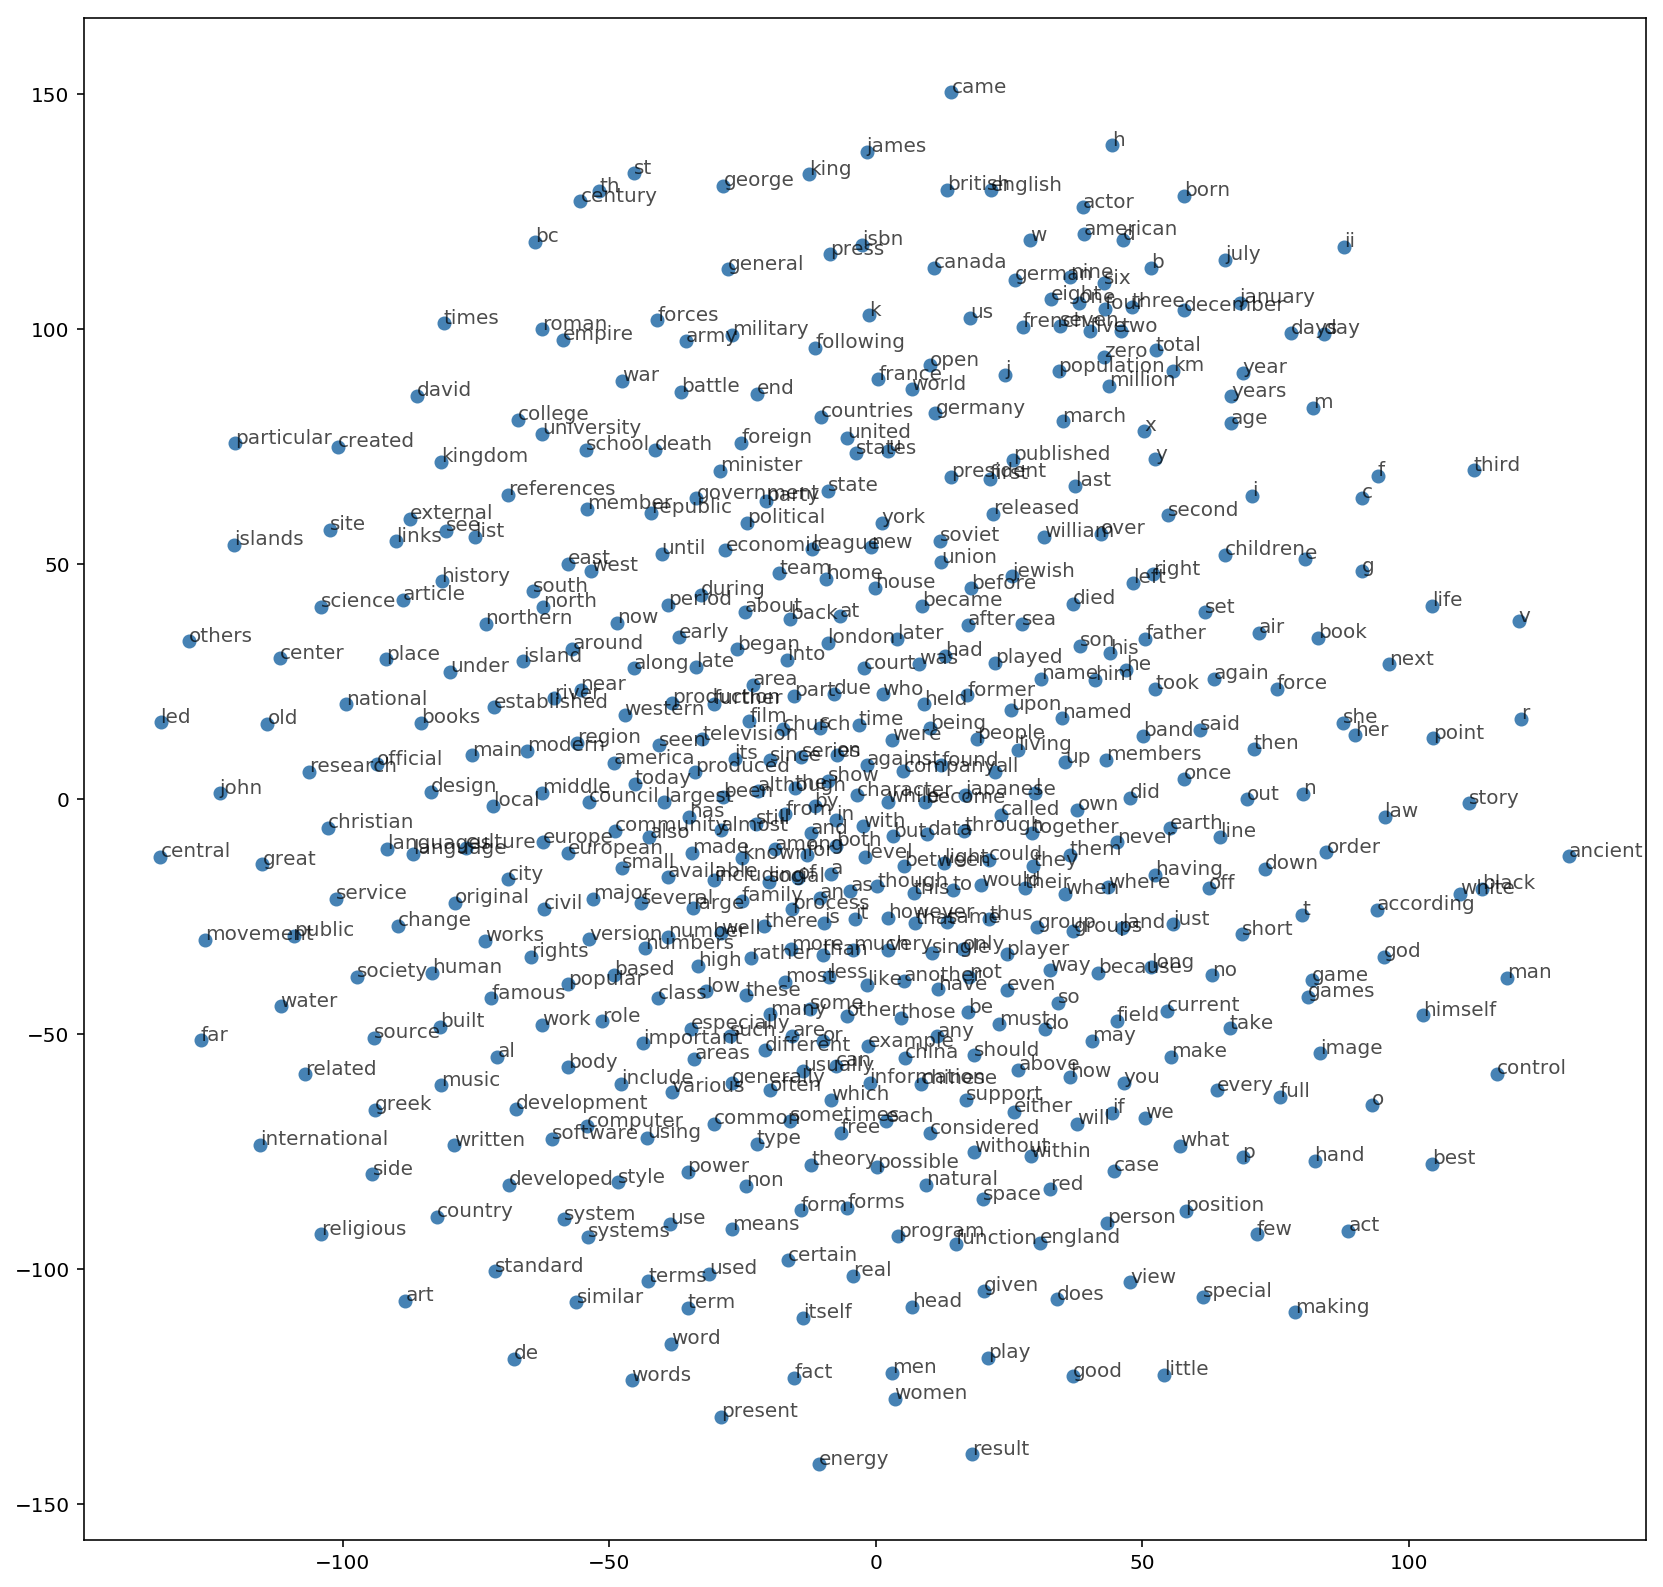

In [19]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [20]:
import os
with open(os.path.join('checkpoints', "metadata.tsv"), 'w') as f:
         for idx in range(len(int_to_vocab)):
            f.write(int_to_vocab[idx] + '\n')

In [21]:
from tensorflow.contrib.tensorboard.plugins import projector
summary_writer = tf.summary.FileWriter('checkpoints', sess.graph)
config = projector.ProjectorConfig()
embedding_conf = config.embeddings.add()
# embedding_conf.tensor_name = 'embedding:0'
embedding_conf.metadata_path = os.path.join('checkpoints', 'metadata.tsv')
projector.visualize_embeddings(summary_writer, config)